<a href="https://colab.research.google.com/github/tincho-mehaudy/DMCyT/blob/master/ArchivosLatex/TP1_Cluster_Todo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# T.P. 1 Algoritmos de Clustering sobre archivos de Spotify

## Levantamos dataset del PreTP

In [499]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

pca = PCA(n_components=2)

# Para visuzalización en notebook
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import seaborn as sns
mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['font.size'] = 14
from IPython.display import Audio, Markdown, Image

def dmd(x):
    display(Markdown(x))

# Números y Datos
import numpy as np
import pandas as pd
import random

# Clustering (scipy)
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster

# Clustering (sklearn)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import adjusted_rand_score, silhouette_score, silhouette_samples
from sklearn.neighbors import NearestNeighbors

# Clustering (otros)
!pip install gower
import gower

!pip install scikit-learn-extra 
from sklearn_extra.cluster import KMedoids 

from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster


import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['font.size'] = 22
from IPython.display import Audio, Markdown, Image, YouTubeVideo, HTML

# Machine learning
from sklearn.datasets import samples_generator, fetch_openml, load_digits
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import MDS, Isomap, SpectralEmbedding, TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

**Levantamos el archivo pickle generado como resultado del PRE-TP1**

In [500]:
import pickle
df_total = pd.read_pickle('df_total.p')
# mostramos dimensiones y primeros registros
print(df_total.shape)
df_total.head(10)

(4082, 71)


id       mp0  ...  energy_logit  loudness_logit
0  00At7PWydsvg7g5xgaYan9  0.354425  ...      2.713416        2.933962
1  00BgcUYkIImsDN5rNjkR1U  0.233490  ...      3.006179        3.154919
2  00WgnFIsY1y84p7mYAJRuF  0.510113  ...      2.614645        1.858252
3  00X2ieWUjpzdNwDU2Jlg6i  0.570225  ...      3.374210        2.286145
4  00isAURAZeKQXv6CW2vckb  0.350877  ...     -1.622804        0.345908
5  00kO4Z0mFAFs6KLlXnaD0f  0.440426  ...     -1.682249        0.399799
6  00nhkvorbdardFjuIi2OOo  0.395587  ...      1.351922        1.194353
7  00r6WtlzQELtNFjSfgQJas  0.336907  ...     -0.994165        0.742764
8  01IEMsoSrK1WXJeuumBZX1  0.678865  ...           NaN        2.286667
9  01K7WtcFrsolt07wYU8zTY  0.332244  ...     -0.748160        0.365772

[10 rows x 71 columns]

In [501]:
# columnas del dataset
df_total.columns

Index(['id', 'mp0', 'mp1', 'mp2', 'mp3', 'mp4', 'mp5', 'mp6', 'mp7', 'mp8',
       'mp9', 'mp10', 'mp11', 'sdp0', 'sdp1', 'sdp2', 'sdp3', 'sdp4', 'sdp5',
       'sdp6', 'sdp7', 'sdp8', 'sdp9', 'sdp10', 'sdp11', 'mt0', 'mt1', 'mt2',
       'mt3', 'mt4', 'mt5', 'mt6', 'mt7', 'mt8', 'mt9', 'mt10', 'mt11', 'sdt0',
       'sdt1', 'sdt2', 'sdt3', 'sdt4', 'sdt5', 'sdt6', 'sdt7', 'sdt8', 'sdt9',
       'sdt10', 'sdt11', 'mt0_norm', 'artists', 'genre', 'release_date',
       'album_name', 'danceability', 'energy', 'loudness', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'speechiness_log', 'liveness_log', 'valence_log', 'valence_logit',
       'acousticness_logit', 'instrumentalness_logit', 'energy_logit',
       'loudness_logit'],
      dtype='object')

In [ ]:
# tipos de datos de las columnas
df_total.info(verbose=True)

Transformamos las categorias a números para usarlas los labels numéricos:

In [503]:
df_total['genre_num']= pd.factorize(df_total['genre'])[0]
df_total[['genre_num','genre']].value_counts()

genre_num  genre            
4          death-metal          486
1          ska                  477
0          drum-and-bass        477
6          trance               475
5          opera                461
8          singer-songwriter    447
7          ambient              442
3          jazz                 421
2          classical            396
dtype: int64

Funciones auxiliares

In [504]:
# silhoutte pertenece a los metodos de VALIDACION INTERNA/NO SUPERVISADA
# esta es la funcion para graficar coeficiente de silhouette, que se usa más adelante
import matplotlib.cm as cm

def grafica_silhouette_2(labels_,d):
  d=d.drop(['genre','genre_num'], axis=1)   
  k=len(labels_.unique())
  #silhouette_avg = silhouette_score(d,labels_,metric='precomputed')
  #sample_silhouette_values = silhouette_samples(d,labels_,metric='precomputed')

  silhouette_avg = silhouette_score(d,labels_)
  sample_silhouette_values = silhouette_samples(d,labels_)

  print("The average silhouette is",silhouette_avg)

  plt.rcParams['figure.figsize'] = (8,6)
  plt.xlim([-0.1, 1])
  plt.ylim([0, len(labels_) + (k + 1) * 10])

  y_lower = 10
  for i in range(k):
      ith_cluster_silhouette_values = sample_silhouette_values[labels_ == i]

      ith_cluster_silhouette_values.sort()

      size_cluster_i = ith_cluster_silhouette_values.shape[0]
      y_upper = y_lower + size_cluster_i

      color = cm.nipy_spectral(float(i) / k)
      plt.fill_betweenx(np.arange(y_lower, y_upper),
                        0, ith_cluster_silhouette_values,
                        facecolor=color, edgecolor=color, alpha=0.7)

      plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

      y_lower = y_upper + 10

  plt.title(("Silhouette analysis on sample data "
                "with k = %d" % k),
                fontsize=14, fontweight='bold')
  plt.xlabel("The silhouette coefficient values",fontsize=14)
  plt.ylabel("Cluster label",fontsize=14)

  # The vertical line for average silhouette score of all the values
  plt.axvline(x=silhouette_avg, color="red", linestyle="--")

  plt.yticks([])  # Clear the yaxis labels / ticks
  plt.xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
  plt.tick_params(axis='both',labelsize=12)
  plt.show()

  

In [505]:
def grafica_silhouette_p(labels_,d):
  k=len(labels_.unique())
  silhouette_avg = silhouette_score(d,labels_,metric='precomputed')
  sample_silhouette_values = silhouette_samples(d,labels_,metric='precomputed')
  print("The average silhouette is",silhouette_avg)
  
  plt.rcParams['figure.figsize'] = (8,6)
  plt.xlim([-0.1, 1])
  plt.ylim([0, len(labels_) + (k + 1) * 10])

  y_lower = 10
  for i in range(k):
      ith_cluster_silhouette_values = sample_silhouette_values[labels_ == i]

      ith_cluster_silhouette_values.sort()

      size_cluster_i = ith_cluster_silhouette_values.shape[0]
      y_upper = y_lower + size_cluster_i

      color = cm.nipy_spectral(float(i) / k)
      plt.fill_betweenx(np.arange(y_lower, y_upper),
                        0, ith_cluster_silhouette_values,
                        facecolor=color, edgecolor=color, alpha=0.7)

      plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

      y_lower = y_upper + 10

  
  plt.title(("Silhouette analysis on sample data "
                "with k = %d" % k),
                fontsize=14, fontweight='bold')
  plt.xlabel("The silhouette coefficient values",fontsize=14)
  plt.ylabel("Cluster label",fontsize=14)

  # The vertical line for average silhouette score of all the values
  plt.axvline(x=silhouette_avg, color="red", linestyle="--")

  plt.yticks([])  # Clear the yaxis labels / ticks
  plt.xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
  plt.tick_params(axis='both',labelsize=12)
  plt.show()

  

In [506]:
def calcula_sse_kmedoids(KM,d):
  se = []
  for i in range(0,KM.n_clusters):
    se.append(sum(d[KM.medoid_indices_[i],KM.labels_==i]**2))
  return sum(se)

In [507]:
def vanDongen(ct):
    n2=2*(sum(ct.apply(sum,axis=1)))
    sumi = sum(ct.apply(np.max,axis=1))
    sumj = sum(ct.apply(np.max,axis=0))
    maxsumi = np.max(ct.apply(sum,axis=1))
    maxsumj = np.max(ct.apply(sum,axis=0))
    vd = (n2 - sumi - sumj)/(n2 - maxsumi - maxsumj)
    return vd

In [508]:
def Hopkins(df,*args):
    n = df.shape[0] # filas
    d = df.shape[1] # columnas
    if not args:
        print("Numero de puntos al azar por defecto")
        m = int(0.1 * n) # cantidad de puntos al azar (default)
    else:
        m = args[0] # cantidad de puntos al azar

    nbrs = NearestNeighbors(n_neighbors=1, algorithm='brute').fit(df) # buscador de vecinos

    rand_ind = random.sample(range(0, n, 1), m) # indices al azar

    ui = []
    wi = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(np.random.normal(size=(1, d)).reshape(1, -1), 2, return_distance=True) # distancia a los nuevos puntos
        ui.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(df[rand_ind[j]].reshape(1, -1), 2, return_distance=True) # distancia a los puntos al azar
        wi.append(w_dist[0][1])

    H = sum(wi) / (sum(ui) + sum(wi))
    return H

In [509]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

def compara_silhouette_kmeans (X,range_n_clusters):

#print(__doc__)

#X= d_meta_total_1
#X=np.asarray(DF1)
#range_n_clusters = [4,9]

  for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)


    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.",fontsize=14)
    ax1.set_xlabel("The silhouette coefficient values",fontsize=14)
    ax1.set_ylabel("Cluster label",fontsize=14)

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.",fontsize=14)
    ax2.set_xlabel("Feature space for the 1st feature",fontsize=14)
    ax2.set_ylabel("Feature space for the 2nd feature",fontsize=14)

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    ax1.tick_params(axis='both',labelsize=12)
    ax2.tick_params(axis='both',labelsize=12)

  plt.show()

In [510]:
def compara_silhouette_kmeds (X,range_n_clusters):

#print(__doc__)

#X= d_meta_total_1
#X=np.asarray(DF1)
#range_n_clusters = [4,9]

  for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMedoids(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)


    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.",fontsize=14)
    ax1.set_xlabel("The silhouette coefficient values",fontsize=14)
    ax1.set_ylabel("Cluster label",fontsize=14)

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.",fontsize=14)
    ax2.set_xlabel("Feature space for the 1st feature",fontsize=14)
    ax2.set_ylabel("Feature space for the 2nd feature",fontsize=14)

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    ax1.tick_params(axis='both',labelsize=12)
    ax2.tick_params(axis='both',labelsize=12)

  plt.show()

In [511]:
def grafica_SIL_SSE_KMEANS(X):

  range_k = [i for i in range(2,15)]
  silh = []
  sse = []
  for k in range_k:
    KM_meta = KMeans(n_clusters=k, random_state=47).fit(X)
  
    silhouette_avg = silhouette_score(X,KM_meta.labels_)

    silh.append(silhouette_avg)
    #print("Para", k,"clusters, el promedio del score de silhouette es:", round(silhouette_avg,4))
    
    sse.append(KM_meta.inertia_)

  plt.plot(range_k,silh,'r.-')
  plt.ylabel('Silhouette promedio', fontsize=14)
  plt.tick_params(axis='both',labelsize=12)
  plt.show()

  plt.plot(range_k,sse,'r.-')
  plt.ylabel('SSE',fontsize=14)
  plt.tick_params(axis='both',labelsize=12)
  plt.show()

In [512]:
def grafica_SIL_SSE_KMEDIODS(X):
  range_k = [i for i in range(2,15)]
  silh = []
  sse = []
  for k in range_k:
    KM_meta =KMedoids(n_clusters=k, random_state=0).fit(X)  

    silhouette_avg = silhouette_score(X,KM_meta.labels_, metric='euclidean')

    silh.append(silhouette_avg)
    #print("Para", k,"clusters, el promedio del score de silhouette es:", round(silhouette_avg,4))
    
    sse.append(KM_meta.inertia_)

  plt.plot(range_k,silh,'r.-')
  plt.ylabel('Silhouette promedio', fontsize=14)
  plt.tick_params(axis='both',labelsize=12)
  plt.show()

  plt.plot(range_k,sse,'r.-')
  plt.ylabel('SSE', fontsize=14)
  plt.tick_params(axis='both',labelsize=12)
  plt.show()


In [513]:
def indices_cofeneticos_varios(X):
  X=scaler.fit_transform(X)

  metrica='euclidean'
  z1 = linkage(X, method='centroid', metric=metrica)
  c, coph_dists = cophenet(z1, pdist(X))
  print ("Indice cofenetico para metodo centroide y metrica", metrica,c)

  z1 = linkage(X, method='average', metric=metrica)
  c, coph_dists = cophenet(z1, pdist(X))
  print ("Indice cofenetico para metodo average y metrica", metrica,c)

  z1 = linkage(X, method='complete', metric=metrica)
  c, coph_dists = cophenet(z1, pdist(X))
  print ("Indice cofenetico para metodo complete y metrica", metrica,c)

  z1 = linkage(X, method='single', metric=metrica)
  c, coph_dists = cophenet(z1, pdist(X))
  print ("Indice cofenetico para metodo single y metrica", metrica,c)

  z1 = linkage(X, method='ward', metric=metrica)
  c, coph_dists = cophenet(z1, pdist(X))
  print ("Indice cofenetico para metodo ward y metrica", metrica,c)

  z1 = linkage(X, method='median', metric=metrica)
  c, coph_dists = cophenet(z1, pdist(X))
  print ("Indice cofenetico para metodo median y metrica", metrica,c)

  metrica='chebyshev'
  z1 = linkage(X, method='average', metric='chebyshev')
  c, coph_dists = cophenet(z1, pdist(X))
  print ("Indice cofenetico para metodo average y metrica", metrica,c)

  z1 = linkage(X, method='complete', metric='chebyshev')
  c, coph_dists = cophenet(z1, pdist(X))
  print ("Indice cofenetico para metodo complete y metrica", metrica,c)

  z1 = linkage(X, method='single', metric='chebyshev')
  c, coph_dists = cophenet(z1, pdist(X))
  print ("Indice cofenetico para metodo single y metrica", metrica,c)

  metrica='mahalanobis'
  z1 = linkage(X, method='average', metric='mahalanobis')
  c, coph_dists = cophenet(z1, pdist(X))
  print ("Indice cofenetico para metodo average y metrica", metrica,c)

  z1 = linkage(X, method='complete', metric='mahalanobis')
  c, coph_dists = cophenet(z1, pdist(X))
  print ("Indice cofenetico para metodo complete y metrica", metrica,c)

  z1 = linkage(X, method='single', metric='mahalanobis')
  c, coph_dists = cophenet(z1, pdist(X))
  print ("Indice cofenetico para metodo single y metrica", metrica,c)

## Generamos 5 conjuntos de datos.
Aplicaremos varios algoritmos de cluster. Las caracteristicas de estos dataframe son:

*   DF1 - Todas las variables numéricas, sin los NA
*   DF2 - Sólo con las variables de timbres y pitches
*   DF3 - Sólo con las variables de timbres
*   DF4 - Sólo con las variables de pitches
*   DF5 - Sólo con Audio Features (Alto Nivel)


 **Generamos DF1- Todas las variables numéricas, elimino NA:**

In [517]:
# pregunta aca, estaban ambas columnas valence_log y valence_logit, no habria que sacar una??
DF = df_total.drop(['id','artists','album_name','release_date','mt0','valence','acousticness', 
                   'instrumentalness','energy','loudness','valence_log'], axis=1)
#DF = df_total.drop(['id','artists','album_name','release_date'], axis=1)   

In [518]:
DF.columns

Index(['mp0', 'mp1', 'mp2', 'mp3', 'mp4', 'mp5', 'mp6', 'mp7', 'mp8', 'mp9',
       'mp10', 'mp11', 'sdp0', 'sdp1', 'sdp2', 'sdp3', 'sdp4', 'sdp5', 'sdp6',
       'sdp7', 'sdp8', 'sdp9', 'sdp10', 'sdp11', 'mt1', 'mt2', 'mt3', 'mt4',
       'mt5', 'mt6', 'mt7', 'mt8', 'mt9', 'mt10', 'mt11', 'sdt0', 'sdt1',
       'sdt2', 'sdt3', 'sdt4', 'sdt5', 'sdt6', 'sdt7', 'sdt8', 'sdt9', 'sdt10',
       'sdt11', 'mt0_norm', 'genre', 'danceability', 'speechiness', 'liveness',
       'tempo', 'speechiness_log', 'liveness_log', 'valence_logit',
       'acousticness_logit', 'instrumentalness_logit', 'energy_logit',
       'loudness_logit', 'genre_num'],
      dtype='object')

In [519]:
DF.describe()

mp0          mp1  ...  loudness_logit    genre_num
count  4082.000000  4082.000000  ...     4080.000000  4082.000000
mean      0.423272     0.423572  ...        1.259677     3.993386
std       0.159062     0.170415  ...        0.935900     2.592131
min       0.000000     0.000000  ...       -4.595120     0.000000
25%       0.310479     0.297935  ...        0.626074     2.000000
50%       0.422400     0.415484  ...        1.353399     4.000000
75%       0.537655     0.551067  ...        1.942827     6.000000
max       0.967849     1.000000  ...        5.823450     8.000000

[8 rows x 60 columns]

In [520]:
DF = DF.dropna()

In [521]:
DF.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3772 entries, 0 to 4081
Data columns (total 61 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   mp0                     3772 non-null   float64
 1   mp1                     3772 non-null   float64
 2   mp2                     3772 non-null   float64
 3   mp3                     3772 non-null   float64
 4   mp4                     3772 non-null   float64
 5   mp5                     3772 non-null   float64
 6   mp6                     3772 non-null   float64
 7   mp7                     3772 non-null   float64
 8   mp8                     3772 non-null   float64
 9   mp9                     3772 non-null   float64
 10  mp10                    3772 non-null   float64
 11  mp11                    3772 non-null   float64
 12  sdp0                    3772 non-null   float64
 13  sdp1                    3772 non-null   float64
 14  sdp2                    3772 non-null   

Aplicamos Silhouette para ver si este conjunto de datos se agrupa naturalmente por los géneros dados:

The average silhouette is 0.025111840198449076


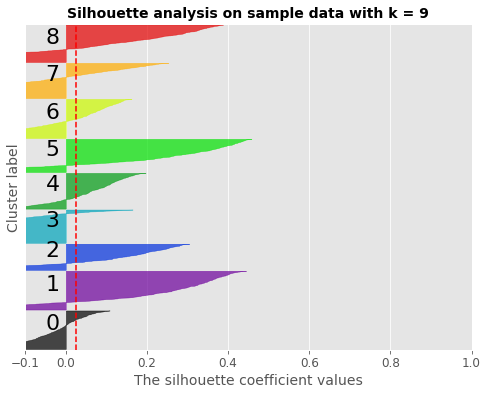

In [522]:
d_meta_total_1 = DF.drop(['genre','genre_num'], axis=1)   
d_meta_total_1 = gower.gower_matrix(d_meta_total_1)

#grafica_silhouette_p(DF['genre_num'],d_meta_total_1)
grafica_silhouette_2(DF['genre_num'],DF)

**Generamos DF2 - Solo con las variables de timbres y pitches:**

In [523]:
DF2 = df_total.drop(['id','artists','album_name','release_date','danceability', 'energy',
       'loudness', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'speechiness_log', 'liveness_log',
       'valence_log', 'valence_logit', 'acousticness_logit',
       'instrumentalness_logit', 'energy_logit', 'loudness_logit','mt0'], axis=1)   
# 'genre',

In [524]:
DF2.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4082 entries, 0 to 4081
Data columns (total 50 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   mp0        4082 non-null   float64
 1   mp1        4082 non-null   float64
 2   mp2        4082 non-null   float64
 3   mp3        4082 non-null   float64
 4   mp4        4082 non-null   float64
 5   mp5        4082 non-null   float64
 6   mp6        4082 non-null   float64
 7   mp7        4082 non-null   float64
 8   mp8        4082 non-null   float64
 9   mp9        4082 non-null   float64
 10  mp10       4082 non-null   float64
 11  mp11       4082 non-null   float64
 12  sdp0       4082 non-null   float64
 13  sdp1       4082 non-null   float64
 14  sdp2       4082 non-null   float64
 15  sdp3       4082 non-null   float64
 16  sdp4       4082 non-null   float64
 17  sdp5       4082 non-null   float64
 18  sdp6       4082 non-null   float64
 19  sdp7       4082 non-null   float64
 20  sdp8    

Aplicamos Silhouette para ver si este conjunto de datos se agrupa naturalmente por los géneros dados:

The average silhouette is 0.028815404939278054


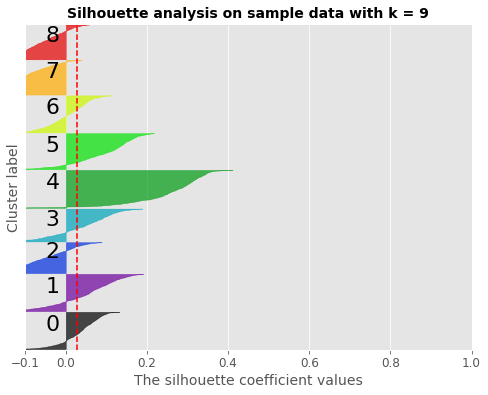

In [525]:
d_meta_total_2 = DF2.drop(['genre','genre_num'], axis=1)   
d_meta_total_2 = gower.gower_matrix(d_meta_total_2)

#grafica_silhouette_p(DF2['genre_num'],d_meta_total_2)
grafica_silhouette_2(DF2['genre_num'],DF2)

**Generamos DF3 - Solo con las variables de timbres:**

In [526]:
DF3 = df_total.drop(['id','artists','album_name','release_date','danceability', 'energy',
       'loudness', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'speechiness_log', 'liveness_log',
       'valence_log', 'valence_logit', 'acousticness_logit',
       'instrumentalness_logit', 'energy_logit', 'loudness_logit','mp0', 'mp1', 'mp2', 'mp3', 'mp4', 'mp5', 'mp6', 'mp7', 'mp8', 'mp9',
       'mp10', 'mp11', 'sdp0', 'sdp1', 'sdp2', 'sdp3', 'sdp4', 'sdp5', 'sdp6',
       'sdp7', 'sdp8', 'sdp9', 'sdp10', 'sdp11','mt0_norm'], axis=1)   
#'genre

In [527]:
DF3.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4082 entries, 0 to 4081
Data columns (total 26 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   mt0        4082 non-null   float64
 1   mt1        4082 non-null   float64
 2   mt2        4082 non-null   float64
 3   mt3        4082 non-null   float64
 4   mt4        4082 non-null   float64
 5   mt5        4082 non-null   float64
 6   mt6        4082 non-null   float64
 7   mt7        4082 non-null   float64
 8   mt8        4082 non-null   float64
 9   mt9        4082 non-null   float64
 10  mt10       4082 non-null   float64
 11  mt11       4082 non-null   float64
 12  sdt0       4082 non-null   float64
 13  sdt1       4082 non-null   float64
 14  sdt2       4082 non-null   float64
 15  sdt3       4082 non-null   float64
 16  sdt4       4082 non-null   float64
 17  sdt5       4082 non-null   float64
 18  sdt6       4082 non-null   float64
 19  sdt7       4082 non-null   float64
 20  sdt8    

Aplicamos Silhouette para ver si este conjunto de datos se agrupa naturalmente por los géneros dados:

The average silhouette is 0.06258321407696894


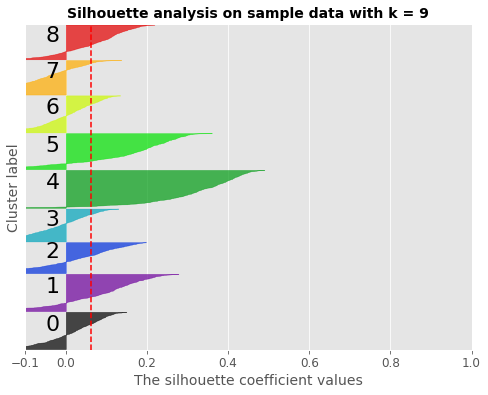

In [528]:
d_meta_total_3 = DF3.drop(['genre','genre_num'], axis=1)   
d_meta_total_3 = gower.gower_matrix(d_meta_total_3)

#grafica_silhouette_p(DF3['genre_num'],d_meta_total_3)
grafica_silhouette_2(DF3['genre_num'],DF3)

**Generamos DF4 - Solo con las variables de pitches:**

In [529]:
DF4 = df_total.drop(['id','artists','album_name','release_date','danceability', 'energy',
       'loudness', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'speechiness_log', 'liveness_log',
       'valence_log', 'valence_logit', 'acousticness_logit',
       'instrumentalness_logit', 'energy_logit', 'loudness_logit','mt0', 'mt1', 'mt2', 'mt3',
       'mt4', 'mt5', 'mt6', 'mt7', 'mt8', 'mt9', 'mt10', 'mt11', 'sdt0',
       'sdt1', 'sdt2', 'sdt3', 'sdt4', 'sdt5', 'sdt6', 'sdt7', 'sdt8', 'sdt9',
       'sdt10', 'sdt11', 'mt0_norm'], axis=1)   
#genre

In [530]:
DF4.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4082 entries, 0 to 4081
Data columns (total 26 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   mp0        4082 non-null   float64
 1   mp1        4082 non-null   float64
 2   mp2        4082 non-null   float64
 3   mp3        4082 non-null   float64
 4   mp4        4082 non-null   float64
 5   mp5        4082 non-null   float64
 6   mp6        4082 non-null   float64
 7   mp7        4082 non-null   float64
 8   mp8        4082 non-null   float64
 9   mp9        4082 non-null   float64
 10  mp10       4082 non-null   float64
 11  mp11       4082 non-null   float64
 12  sdp0       4082 non-null   float64
 13  sdp1       4082 non-null   float64
 14  sdp2       4082 non-null   float64
 15  sdp3       4082 non-null   float64
 16  sdp4       4082 non-null   float64
 17  sdp5       4082 non-null   float64
 18  sdp6       4082 non-null   float64
 19  sdp7       4082 non-null   float64
 20  sdp8    

Aplicamos Silhouette para ver si este conjunto de datos se agrupa naturalmente por los géneros dados:

The average silhouette is -0.03215442807291994


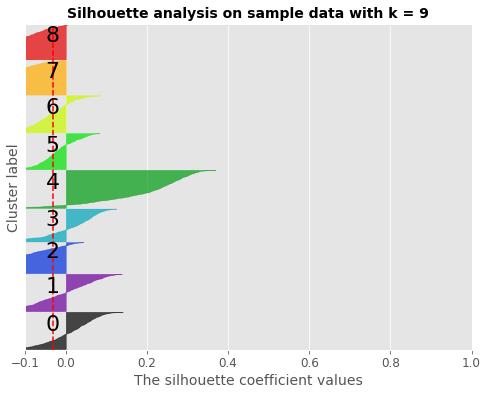

In [531]:
d_meta_total_4 = DF4.drop(['genre','genre_num'], axis=1)   
d_meta_total_4 = gower.gower_matrix(d_meta_total_4)

#grafica_silhouette_p(DF4['genre_num'],d_meta_to#tal_4)
grafica_silhouette_2(DF4['genre_num'],DF4)


REVISAR Los generos que estan peor clasificados son  7-ambient , 6- trance, 3-jazz , 0-drum-and-bass. El genero 4-death-metal, esta muy bien clasificado. Mientras que el 5-opera  y 1-ska , con una buena clasificacion

**Generamos DF5 - Solo con Audio Features (Alto Nivel):**

In [532]:
# pregunta aca, idem variable valence_log y valence_logit
DF5 = df_total[['danceability', 'tempo', 'speechiness_log', 'liveness_log',
        'valence_logit', 'acousticness_logit',
       'instrumentalness_logit', 'energy_logit', 'loudness_logit','genre','genre_num']] 
DF5.head()

danceability     tempo  ...          genre  genre_num
0      0.533827  0.810248  ...  drum-and-bass          0
1      0.382664  0.814705  ...  drum-and-bass          0
2      0.468288  0.815129  ...  drum-and-bass          0
3      0.464059  0.419984  ...            ska          1
4      0.238901  0.320465  ...      classical          2

[5 rows x 11 columns]

In [533]:
DF5 = DF5.dropna()
DF5.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3772 entries, 0 to 4081
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   danceability            3772 non-null   float64
 1   tempo                   3772 non-null   float64
 2   speechiness_log         3772 non-null   float64
 3   liveness_log            3772 non-null   float64
 4   valence_logit           3772 non-null   float64
 5   acousticness_logit      3772 non-null   float64
 6   instrumentalness_logit  3772 non-null   float64
 7   energy_logit            3772 non-null   float64
 8   loudness_logit          3772 non-null   float64
 9   genre                   3772 non-null   object 
 10  genre_num               3772 non-null   int64  
dtypes: float64(9), int64(1), object(1)
memory usage: 353.6+ KB


Aplicamos Silhouette para ver si este conjunto de datos se agrupa naturalmente por los géneros dados:

The average silhouette is 0.020518749716107912


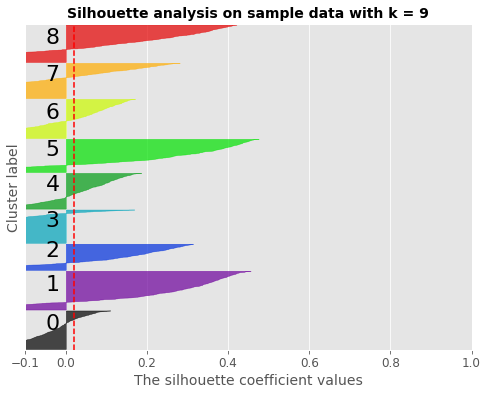

In [534]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

#antes escalamos los datos porque no acepta valores negativos
scaled_df = scaler.fit_transform(DF5.drop(['genre','genre_num'], axis=1))

d_meta_total_5 = scaled_df 
d_meta_total_5 = gower.gower_matrix(d_meta_total_5)

#grafica_silhouette_p(DF5['genre_num'],d_meta_total_5)
grafica_silhouette_2(DF5['genre_num'],DF5)

# Algoritmo KMeans

## DF1 
**Todas las variables numéricas, sin los NA**



Con los gráficos del promedio de Silhouette y SSE, tratamos de ver cuál sería la cantidad optima de clusters para este conjunto de datos

In [536]:
DF1= DF.drop(['genre','genre_num'], axis=1)

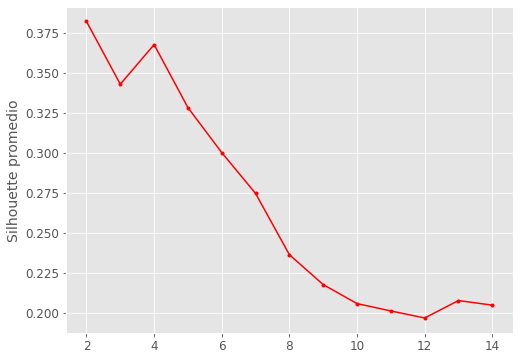

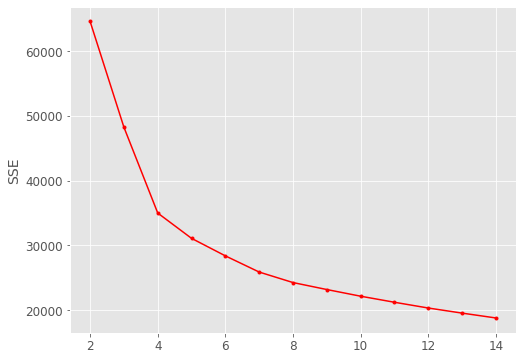

In [537]:
grafica_SIL_SSE(DF1)

For n_clusters = 4 The average silhouette_score is : 0.3654730185197661
For n_clusters = 9 The average silhouette_score is : 0.21651375789894853


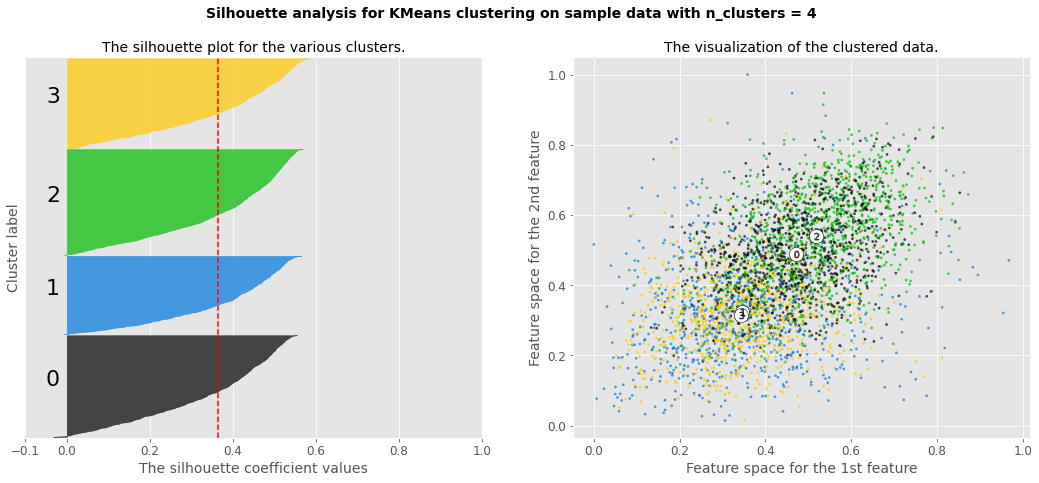

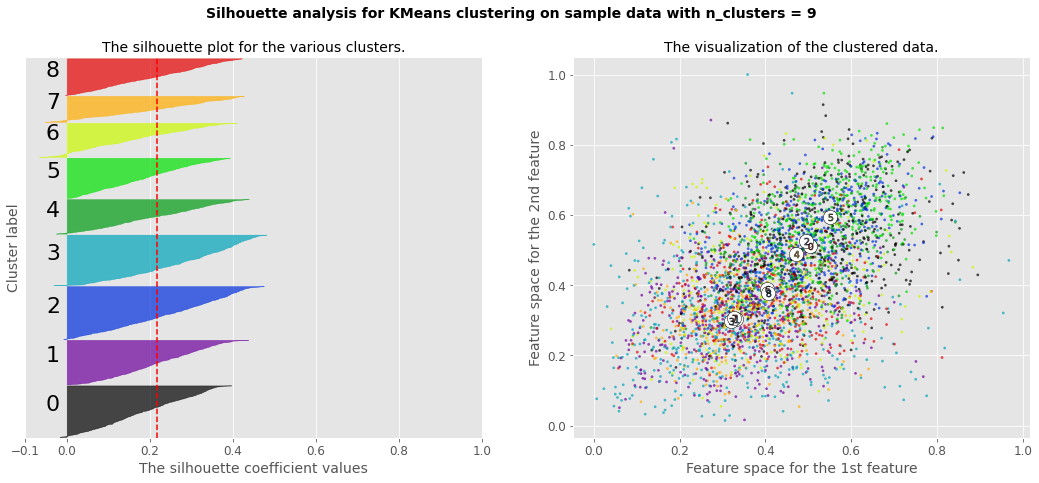

In [482]:
compara_silhouette_kmeans(np.asarray(DF1),[4,9])

Aplicamos el algoritmo kMeans para k=9. Generamos la matriz de confusion como método de validacion externa para ver si los agrupamientos son similares a los reales

In [538]:
kmeans1 = KMeans(n_clusters=9, random_state=47).fit(DF1)

tmp1 = pd.DataFrame({'Labels': DF.genre, 'Clusters': kmeans1.labels_})# Create a DataFrame with labels and varieties as columns: df
ct1 = pd.crosstab(tmp1['Labels'], tmp1['Clusters']) # Create crosstab: ct
ct1

Clusters             0    1    2    3    4    5    6    7    8
Labels                                                        
ambient              1  183    1   64    0    3   17  146    3
classical            0  224    1    0    0   19   29   38    0
death-metal        156    1    0   49    0    0    1    6  212
drum-and-bass      167    0    6  132   12    0    0    1  140
jazz                 1   61   98   23    5   12   92  104    0
opera                0   26   12    0    0  181  165   10    0
singer-songwriter   17    8  198    4   36    9  155   18    0
ska                 82    1   56   13  284    0    1   23    1
trance             126    4   13  239   21    0    0    6   55

### Indice de Rand 

In [539]:
from sklearn.metrics import adjusted_rand_score

ari1 = adjusted_rand_score(DF.genre, kmeans1.labels_)
ari1

0.2675423992895609

### Medida de Van Dongen
Medida mejorada de la pureza

In [540]:
vanDongen(ct1)

0.6027565084226646

### El método de Hopkins 
Consiste en generar p puntos distribuidos al azar en el espacio muestral, y además extraer p puntos reales del dataset. Luego se calculan las distancias a los vecinos más próximos dentro del subconjunto de datos generados al azar (u) y dentro del subconjunto de datos extraídos del dataset (w), con estos se calcula el coeficiente de Hopkins (H) como sum_i(w_i)/(sum_i(u_i)+sum_i(w_i)). Si los nuevos puntos están igual de alejados que los tomados al azar, entonces sum(u) ~ sum(w) y H ~ 0.5. En cambio, si sum(u) >> sum(w), es decir que en promedio están menos agrupados los que se encuentran al azar, entonces H << 0.5.

In [542]:
Hopkins (scaler.fit_transform(DF1))

Numero de puntos al azar por defecto


0.07910398020776398

### Tecnicas de reduccion de dimensionalidad


In [548]:
#Xred = pca.fit_transform(DF1)
#Y=pd.factorize(DF.genre)[0]

**T-distributed Stochastic Neighbor Embedding (TSNE)**

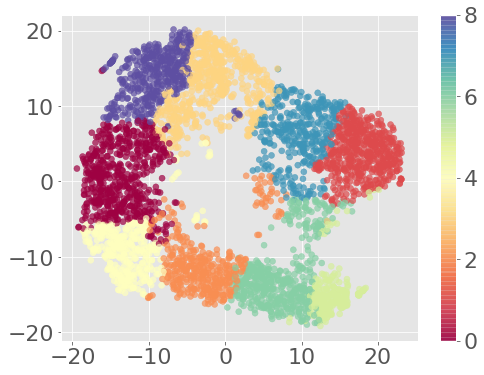

In [549]:
tsne = TSNE(n_components=2,perplexity=200)
Y=kmeans1.labels_
Xred = tsne.fit_transform(DF1)
plt.scatter(Xred[:,0],Xred[:,1],c=Y,cmap=plt.cm.Spectral,alpha=0.7)
plt.colorbar();

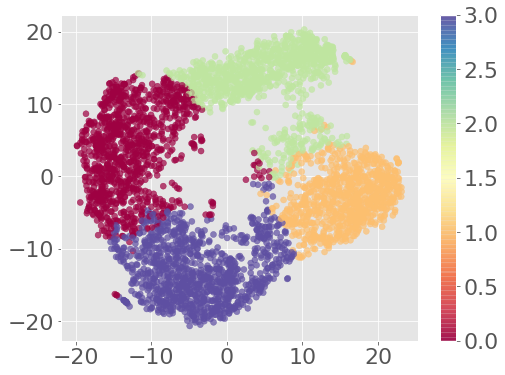

In [550]:
tsne = TSNE(n_components=2,perplexity=200)
Y=kmeans1.labels_
kmeans1_1 = KMeans(n_clusters=4, random_state=47).fit(DF1)
Y=kmeans1_1.labels_
Xred = tsne.fit_transform(DF1)
plt.scatter(Xred[:,0],Xred[:,1],c=Y,cmap=plt.cm.Spectral,alpha=0.7)
plt.colorbar();

## DF2 
**Sólo con las variables de timbres y pitches**

In [551]:
DF2_2= DF2.drop(['genre','genre_num'], axis=1)

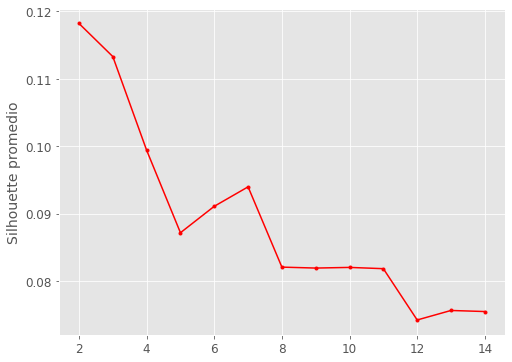

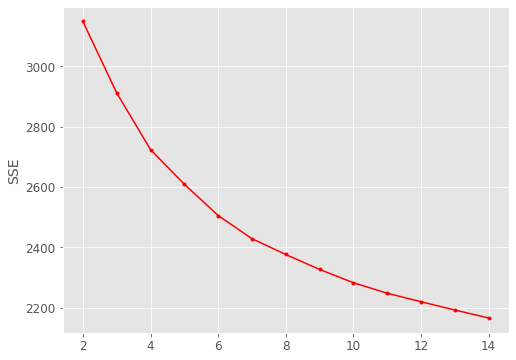

In [552]:
grafica_SIL_SSE(DF2_2)

For n_clusters = 7 The average silhouette_score is : 0.09358734082650871
For n_clusters = 9 The average silhouette_score is : 0.08635006404841133


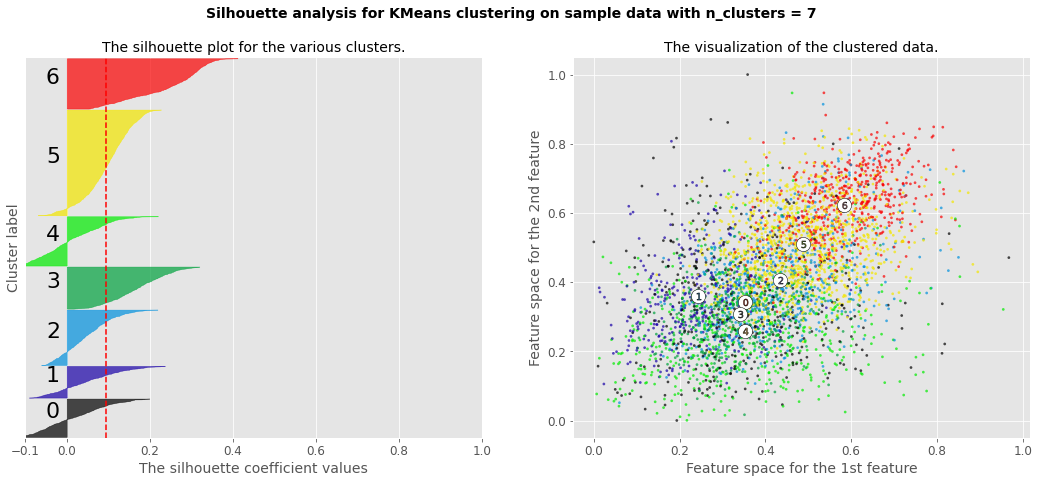

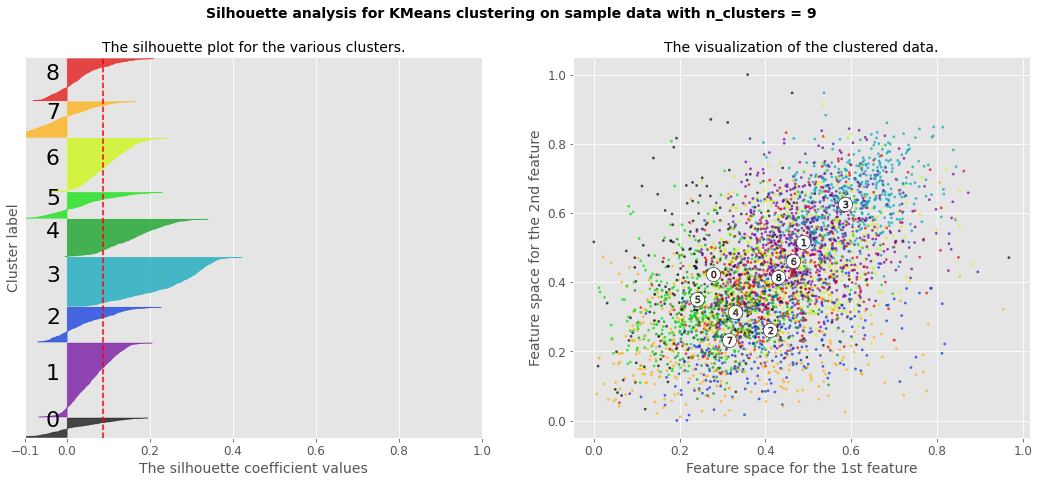

In [556]:
compara_silhouette_kmeans(np.asarray(DF2_2),[7,9])

In [557]:
kmeans2 = KMeans(n_clusters=9, random_state=0).fit(DF2_2)

tmp2 = pd.DataFrame({'Labels': DF2.genre, 'Clusters': kmeans2.labels_})# Create a DataFrame with labels and varieties as columns: df
ct2 = pd.crosstab(tmp2['Labels'], tmp2['Clusters']) # Create crosstab: ct
ct2

Clusters             0    1    2    3    4   5    6    7    8
Labels                                                       
ambient            100   21    5  115   75  61   35    7   23
classical          101   16    2   51   69  66    1   86    4
death-metal          2   36  440    1    2   1    3    1    0
drum-and-bass        3  184    5   14    6  12  226    1   26
jazz                14   43    0   48   23  14   32   30  217
opera               19   18    0   33   36  34    0  308   13
singer-songwriter   53   35    0   87  109  65    4    0   94
ska                  2  270   31    9    7  12   18    0  128
trance               3   98    4   10   13  15  298    2   32

### Calculamos los indices de Rand, Van Dongen y Hopkins

In [558]:
from sklearn.metrics import adjusted_rand_score

# este es el mejor indice?
ari2 = adjusted_rand_score(DF2.genre, kmeans2.labels_)
ari2

0.2891483283442294

In [559]:
vanDongen(ct2)
# este es el mejor indice?

0.5973839298548225

In [560]:
Hopkins (scaler.fit_transform(DF2_2))

Numero de puntos al azar por defecto


0.07287194916025334

### Tecnicas de reduccion de dimensionalidad


**T-distributed Stochastic Neighbor Embedding (TSNE)**

In [561]:
Xred = pca.fit_transform(DF2_2)
#Y=pd.factorize(DF2.genre)[0]
Y=kmeans2.labels_

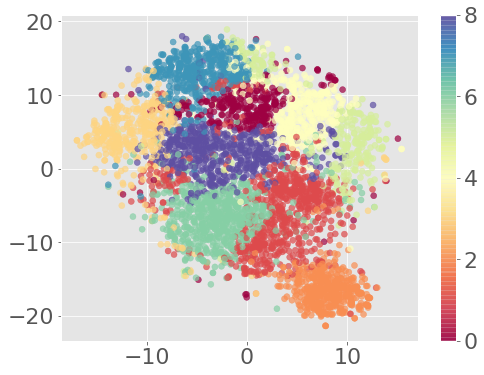

In [563]:
tsne = TSNE(n_components=2,perplexity=200)
Xred = tsne.fit_transform(DF2_2)
plt.scatter(Xred[:,0],Xred[:,1],c=Y,cmap=plt.cm.Spectral,alpha=0.7)
plt.colorbar();

## DF3 
**Sólo con las variables de timbres**

In [564]:
DF3_2= DF3.drop(['genre','genre_num'], axis=1)

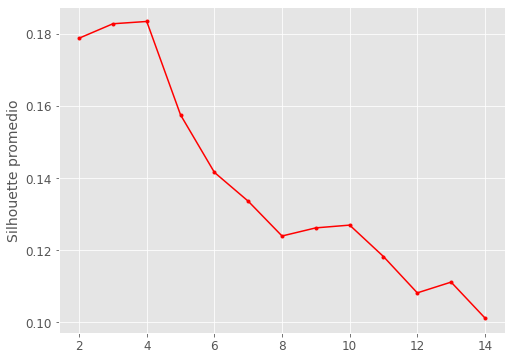

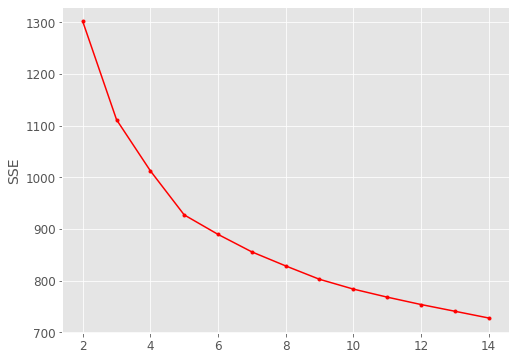

In [565]:
grafica_SIL_SSE_KMEANS(DF3_2)

For n_clusters = 4 The average silhouette_score is : 0.18352491320651537
For n_clusters = 9 The average silhouette_score is : 0.12703409327239373


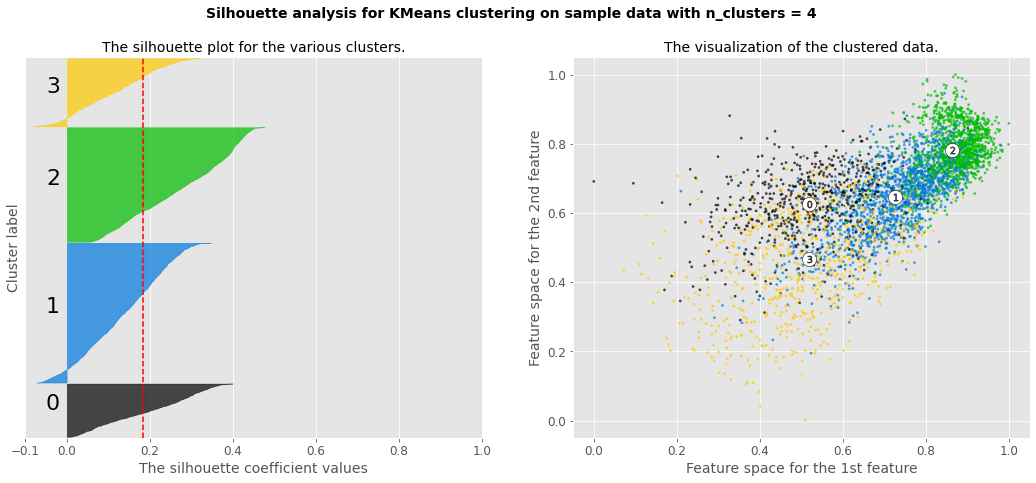

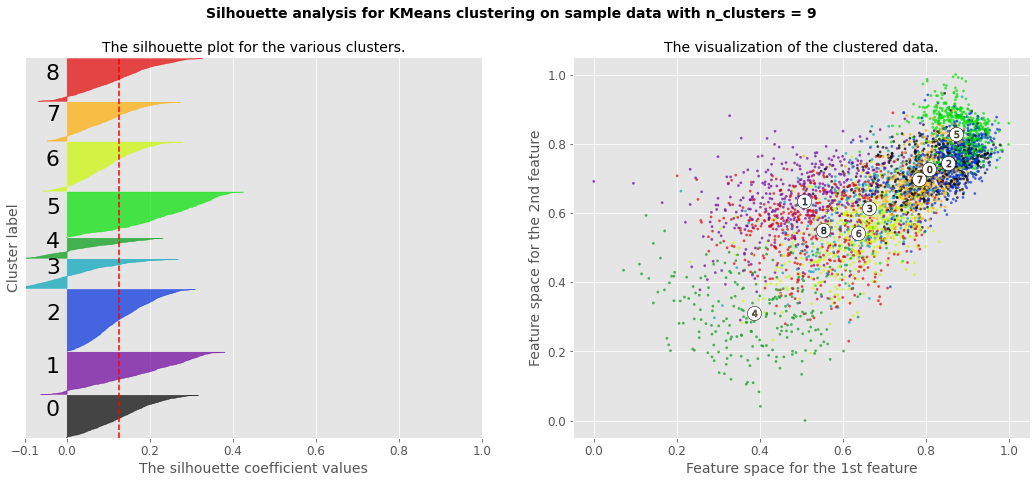

In [566]:
compara_silhouette_kmeans(np.asarray(DF3_2),[4,9])

In [567]:
kmeans3 = KMeans(n_clusters=9, random_state=0).fit(DF3_2)
kmeans3.labels_

tmp3 = pd.DataFrame({'Labels': DF3.genre, 'Clusters': kmeans3.labels_})# Create a DataFrame with labels and varieties as columns: df
ct3= pd.crosstab(tmp3['Labels'], tmp3['Clusters']) # Create crosstab: ct
ct3

Clusters             0    1    2    3    4    5    6    7    8
Labels                                                        
ambient              1  112   16   20  134    9   16   13  121
classical            3   16   78    0   63    4    1    1  230
death-metal          2    0    0   41    1  435    0    2    5
drum-and-bass       17    5    0  267    0    6   20  161    1
jazz                74  145   23   19    7    1  126   14   12
opera               19   25  333    6    3    0    4    0   71
singer-songwriter   70  247    2   49    0    1   64    2   12
ska                265    4    0  119    0   27   58    4    0
trance               7    3    2  169    2    1   42  245    4

### Calculamos los indices de Rand, Van Dongen y Hopkins

In [568]:
from sklearn.metrics import adjusted_rand_score

# este es el mejor indice?
ari3 = adjusted_rand_score(DF3.genre, kmeans3.labels_)
ari3

0.34403501421051147

In [569]:
vanDongen(ct3)
# este es el mejor indice?

0.5124499141385231

In [570]:
Hopkins (scaler.fit_transform(DF3_2))

Numero de puntos al azar por defecto


0.05698756283217057

### Tecnicas de reduccion de dimensionalidad


In [ ]:
#Xred = pca.fit_transform(DF3_2)
#Y=pd.factorize(DF3.genre)[0]

**T-distributed Stochastic Neighbor Embedding (TSNE)**

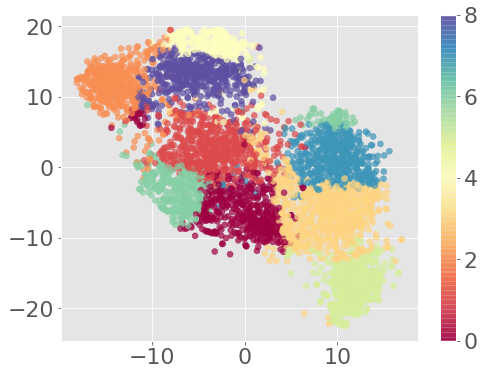

In [571]:
tsne = TSNE(n_components=2,perplexity=200)
Y=kmeans3.labels_
Xred = tsne.fit_transform(DF3_2)
plt.scatter(Xred[:,0],Xred[:,1],c=Y,cmap=plt.cm.Spectral,alpha=0.7)
plt.colorbar();

## DF4 
**Sólo con las variables de pitches**

In [573]:
DF4_2= DF4.drop(['genre','genre_num'], axis=1)

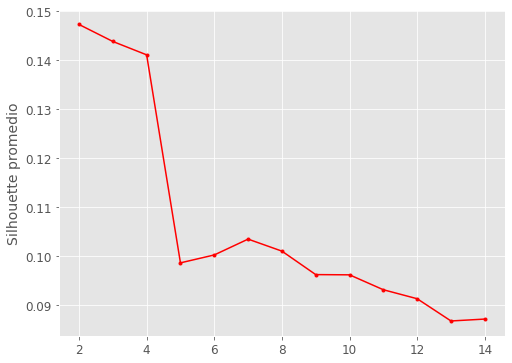

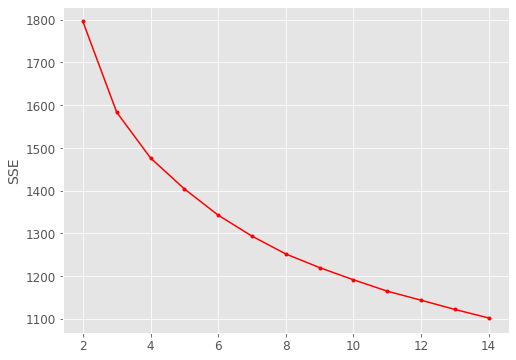

In [574]:
grafica_SIL_SSE_KMEANS(DF4_2)

For n_clusters = 3 The average silhouette_score is : 0.14402095093914044
For n_clusters = 9 The average silhouette_score is : 0.0966040526983277


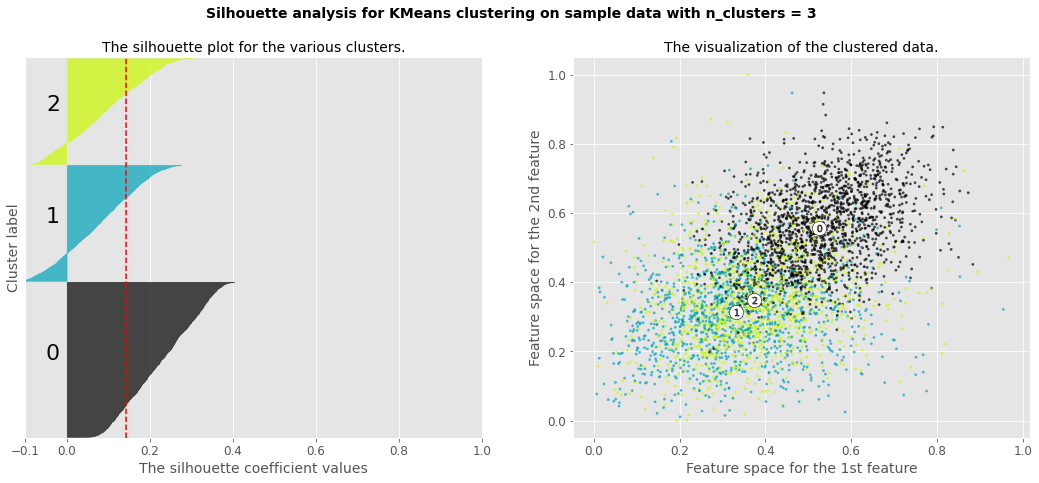

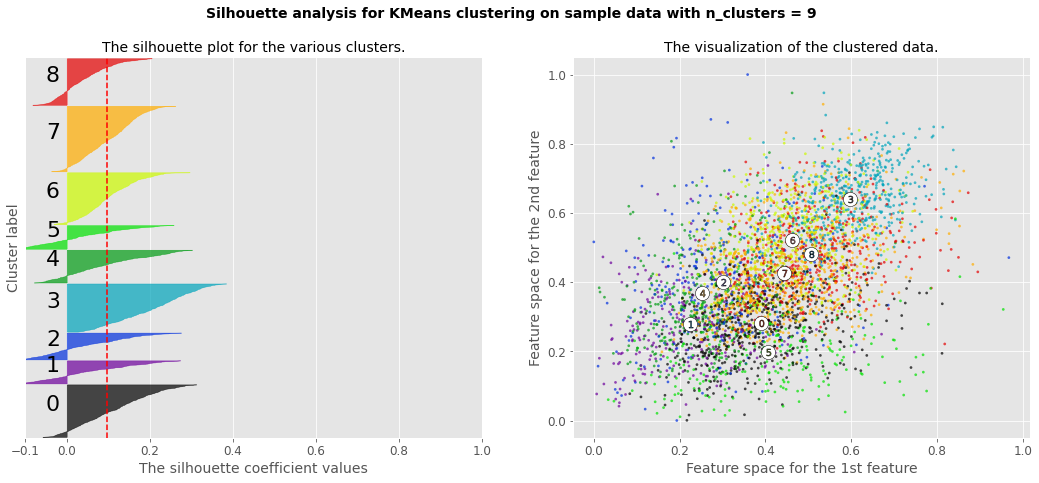

In [575]:
compara_silhouette_kmeans(np.asarray(DF4_2),[3,9])

In [576]:
kmeans4 = KMeans(n_clusters=9, random_state=0).fit(DF4_2)
kmeans4.labels_

tmp4 = pd.DataFrame({'Labels': DF4.genre, 'Clusters': kmeans4.labels_})# Create a DataFrame with labels and varieties as columns: df
ct4= pd.crosstab(tmp4['Labels'], tmp4['Clusters']) # Create crosstab: ct
ct4

Clusters             0   1    2    3   4   5   6    7    8
Labels                                                    
ambient              6  57   41   39  79  84  56   33   47
classical            2  51   81    6  79  30  62   18   67
death-metal        395   2    3   21   1   1   1   50   12
drum-and-bass       11   0   22  131   0   9  21  215   68
jazz                11   5  165   33  19  35  20   47   86
opera                2  21  131    6  27  48  69   42  115
singer-songwriter    2  67   70   15  60  60  71   14   88
ska                 70   3   40   53   7  19  37   88  160
trance              38   0   16  202   0   6  18  123   72

### Calculamos los indices de Rand, Van Dongen y Hopkins

In [577]:
from sklearn.metrics import adjusted_rand_score

# este es el mejor indice?
ari4 = adjusted_rand_score(DF4.genre, kmeans4.labels_)
ari4

0.1488511557612359

In [578]:
vanDongen(ct4)
# este es el mejor indice?

0.7475226195605342

In [579]:
Hopkins (scaler.fit_transform(DF4_2))

Numero de puntos al azar por defecto


0.06279388604863458

### Tecnicas de reduccion de dimensionalidad


**T-distributed Stochastic Neighbor Embedding (TSNE)**

In [ ]:
#Xred = pca.fit_transform(DF4_2)
#Y=pd.factorize(DF4.genre)[0]

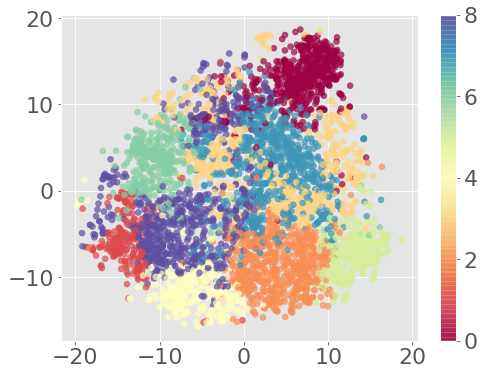

In [580]:
tsne = TSNE(n_components=2,perplexity=200)
Xred = tsne.fit_transform(DF4_2)
Y=kmeans4.labels_
plt.scatter(Xred[:,0],Xred[:,1],c=Y,cmap=plt.cm.Spectral,alpha=0.7)
plt.colorbar();

## DF5 
**Sólo con Audio Features (Alto Nivel)**

In [581]:
DF5_2= DF5.drop(['genre','genre_num'], axis=1)

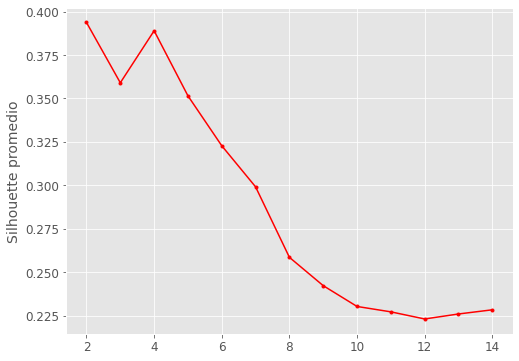

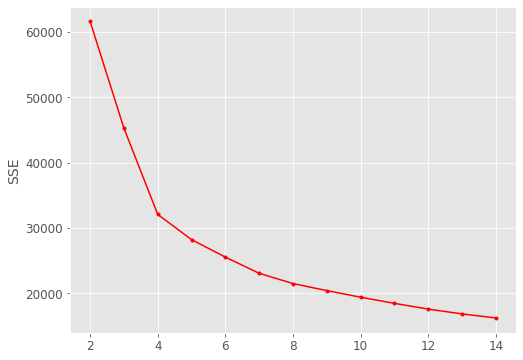

In [582]:
grafica_SIL_SSE_KMEANS(DF5_2)

For n_clusters = 4 The average silhouette_score is : 0.3889793035830587
For n_clusters = 9 The average silhouette_score is : 0.2408452072108109


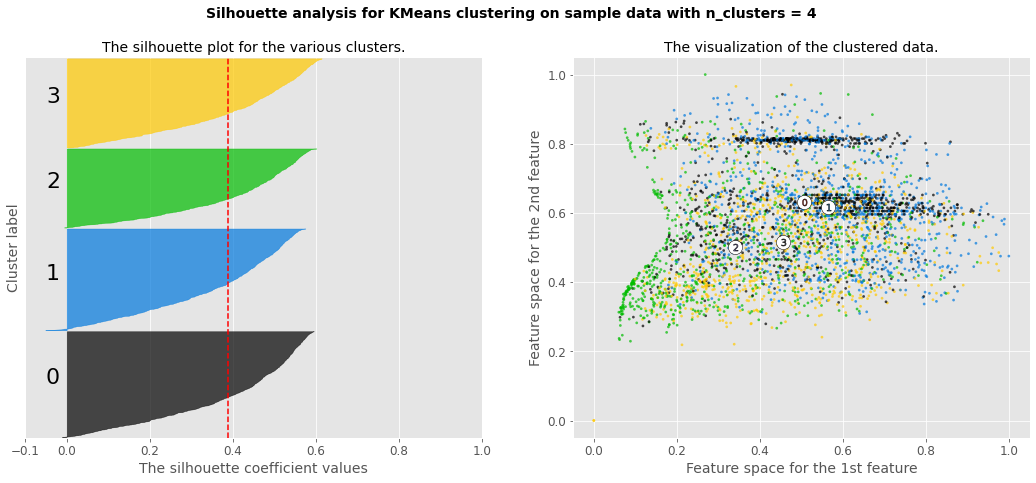

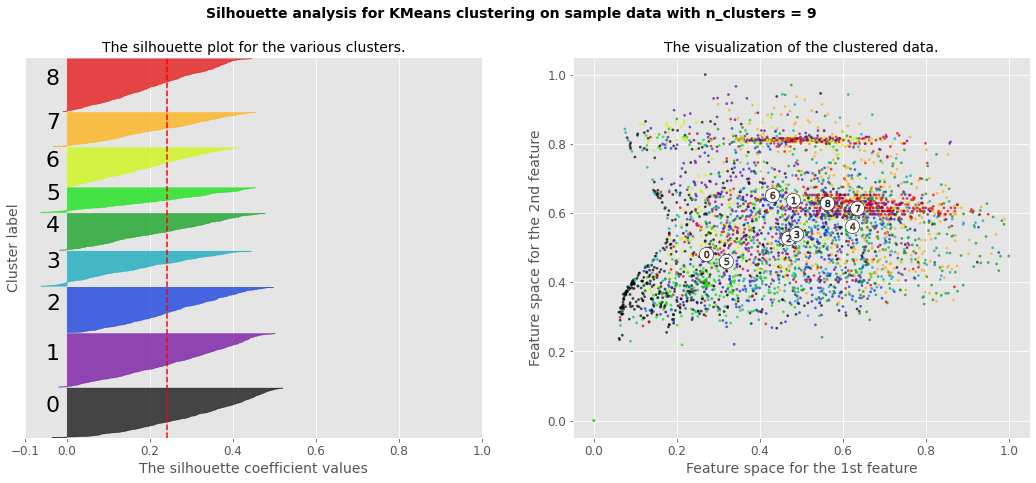

In [583]:
compara_silhouette_kmeans(np.asarray(DF5_2),[4,9])

In [584]:
kmeans5 = KMeans(n_clusters=9, random_state=0).fit(DF5_2)
kmeans5.labels_

tmp5 = pd.DataFrame({'Labels': DF5.genre, 'Clusters': kmeans5.labels_})# Create a DataFrame with labels and varieties as columns: df
ct5= pd.crosstab(tmp5['Labels'], tmp5['Clusters']) # Create crosstab: ct
ct5

Clusters             0    1    2    3    4    5    6    7    8
Labels                                                        
ambient              1    1   65  153    4  176    0    2   16
classical            1    0    0   39   19  223    0    0   29
death-metal          0  156   59    6    0    1    0  202    1
drum-and-bass        6  165  133    1    0    0   12  141    0
jazz                98    1   23  104   13   61    5    0   91
opera               11    0    0   10  181   29    0    0  163
singer-songwriter  199   17    4   18   10    8   34    0  155
ska                 60   82   13   23    0    1  280    1    1
trance              13  128  238    6    0    4   21   54    0

### Calculamos los indices de Rand, Van Dongen y Hopkins

Indice de Rand y Van Dongen-> Validacion Externa
Hopkins -> mide Tendencia al Clustering (No discrimina por algoritmo, evalua el dataset en general)

In [585]:
from sklearn.metrics import adjusted_rand_score

# este es el mejor indice?
ari5 = adjusted_rand_score(DF5.genre, kmeans5.labels_)
ari5

0.26330483408872396

In [586]:
vanDongen(ct5)
# este es el mejor indice?

0.6082695252679938

In [587]:
Hopkins (scaler.fit_transform(DF5_2))

Numero de puntos al azar por defecto


0.0473057893463185

### Tecnicas de reduccion de dimensionalidad


**T-distributed Stochastic Neighbor Embedding (TSNE)**

In [ ]:
#Xred = pca.fit_transform(DF5_2)
#Y=pd.factorize(DF5.genre)[0]

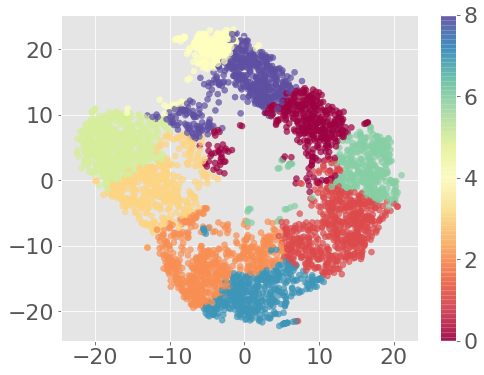

In [588]:
tsne = TSNE(n_components=2,perplexity=200)
Xred = tsne.fit_transform(DF5_2)
Y=kmeans5.labels_
plt.scatter(Xred[:,0],Xred[:,1],c=Y,cmap=plt.cm.Spectral,alpha=0.7)
plt.colorbar();

# Algoritmo PAM o KMedioides

##DF1 
**Todas las variables numéricas, sin los NA**



Con los gráficos del promedio de Silhouette y SSE, tratamos de ver cuál sería la cantidad optima de clusters para este conjunto de datos

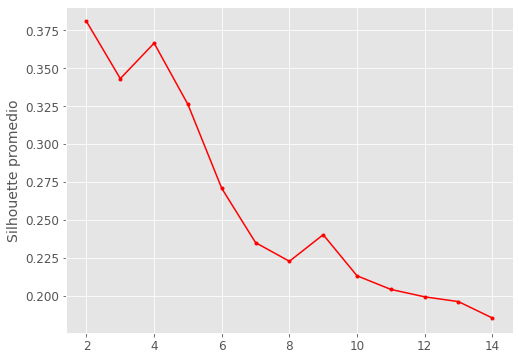

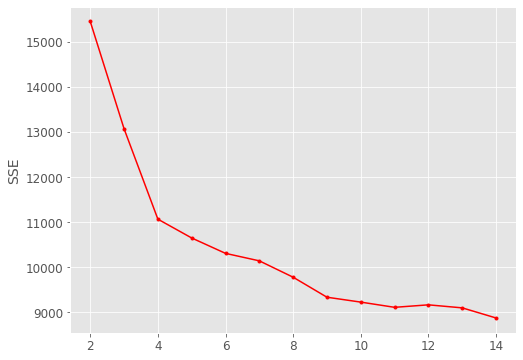

In [589]:
grafica_SIL_SSE_KMEDIODS(DF1)

For n_clusters = 4 The average silhouette_score is : 0.36644257364549343
For n_clusters = 9 The average silhouette_score is : 0.24014829171520746


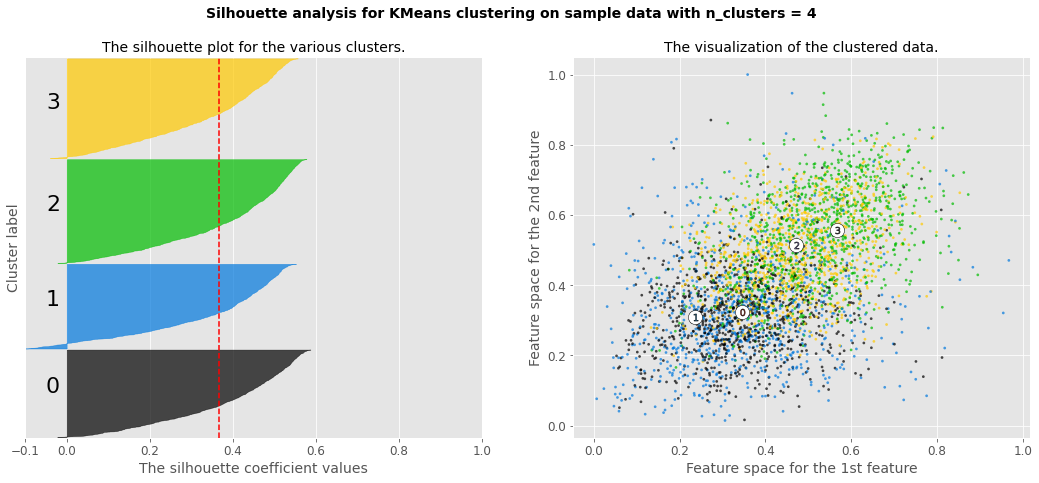

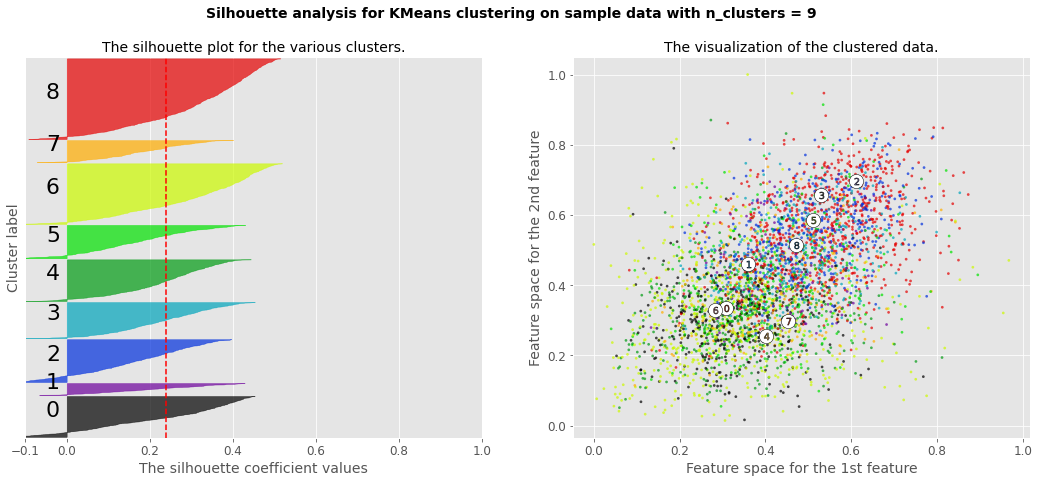

In [590]:
compara_silhouette_kmeds (np.asarray(DF1),[4,9])


Aplicamos el algoritmo kMeans para k=9. Generamos la matriz de confusion como método de validacion externa para ver si los agrupamientos son similares a los reales

In [591]:
kmeds1 = KMedoids(n_clusters=9, random_state=10).fit(DF1)  

tmp1_med = pd.DataFrame({'Labels': DF.genre, 'Clusters': kmeds1.labels_})# Create a DataFrame with labels and varieties as columns: df
ct1_med = pd.crosstab(tmp1['Labels'], tmp1['Clusters']) # Create crosstab: ct
ct1_med

Clusters             0    1    2    3    4    5    6    7    8
Labels                                                        
ambient              1  183    1   64    0    3   17  146    3
classical            0  224    1    0    0   19   29   38    0
death-metal        156    1    0   49    0    0    1    6  212
drum-and-bass      167    0    6  132   12    0    0    1  140
jazz                 1   61   98   23    5   12   92  104    0
opera                0   26   12    0    0  181  165   10    0
singer-songwriter   17    8  198    4   36    9  155   18    0
ska                 82    1   56   13  284    0    1   23    1
trance             126    4   13  239   21    0    0    6   55

### Calculamos los indices de Rand y Van Dongen 

In [592]:
from sklearn.metrics import adjusted_rand_score

# este es el mejor indice?
ari1 = adjusted_rand_score(DF.genre, kmeds1.labels_)
ari1

0.27937694054428736

In [593]:
vanDongen(ct1_med)
# este es el mejor indice?

0.6027565084226646

### Tecnicas de reduccion de dimensionalidad


**T-distributed Stochastic Neighbor Embedding (TSNE)**

In [ ]:
#Xred = pca.fit_transform(DF1)
#Y=pd.factorize(DF.genre)[0]

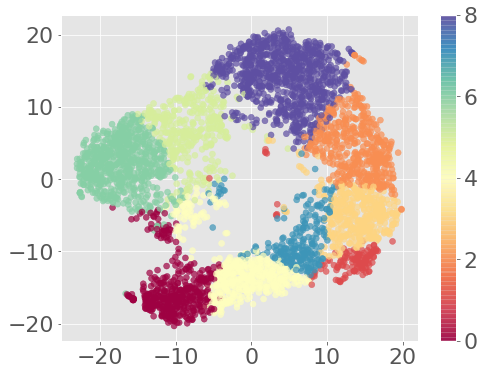

In [594]:
tsne = TSNE(n_components=2,perplexity=200)
Y=kmeds1.labels_
Xred = tsne.fit_transform(DF1)
plt.scatter(Xred[:,0],Xred[:,1],c=Y,cmap=plt.cm.Spectral,alpha=0.7)
plt.colorbar();

##DF2 
**Sólo con las variables de timbres y pitches**



Con los gráficos del promedio de Silhouette y SSE, tratamos de ver cuál sería la cantidad optima de clusters para este conjunto de datos

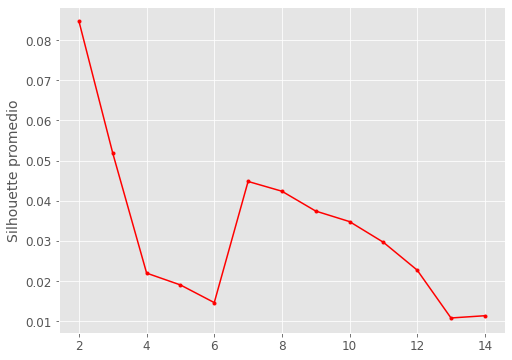

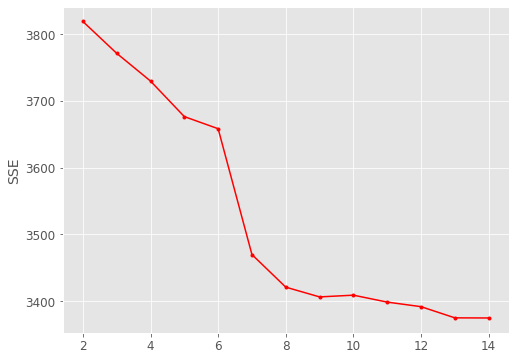

In [595]:
grafica_SIL_SSE_KMEDIODS(DF2_2)

For n_clusters = 7 The average silhouette_score is : 0.0448017345365107
For n_clusters = 9 The average silhouette_score is : 0.037420922713683115


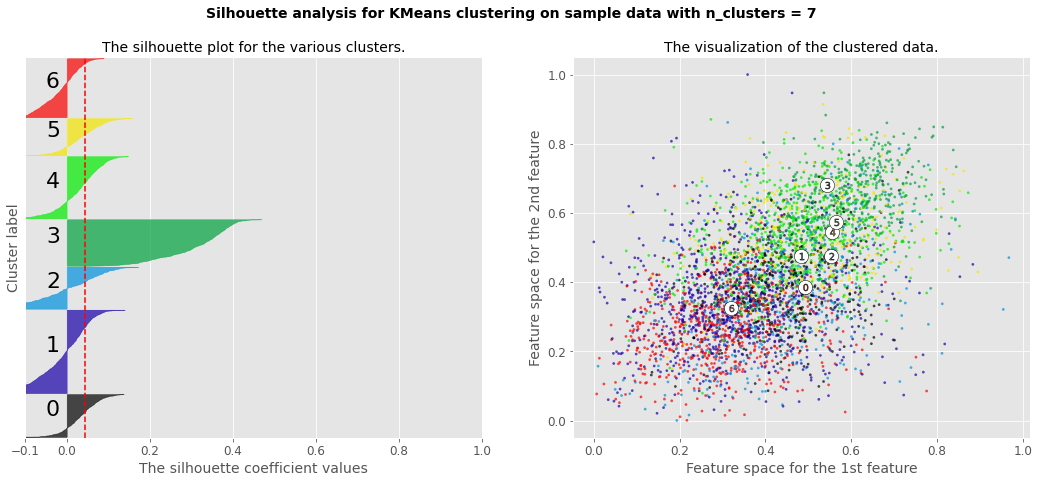

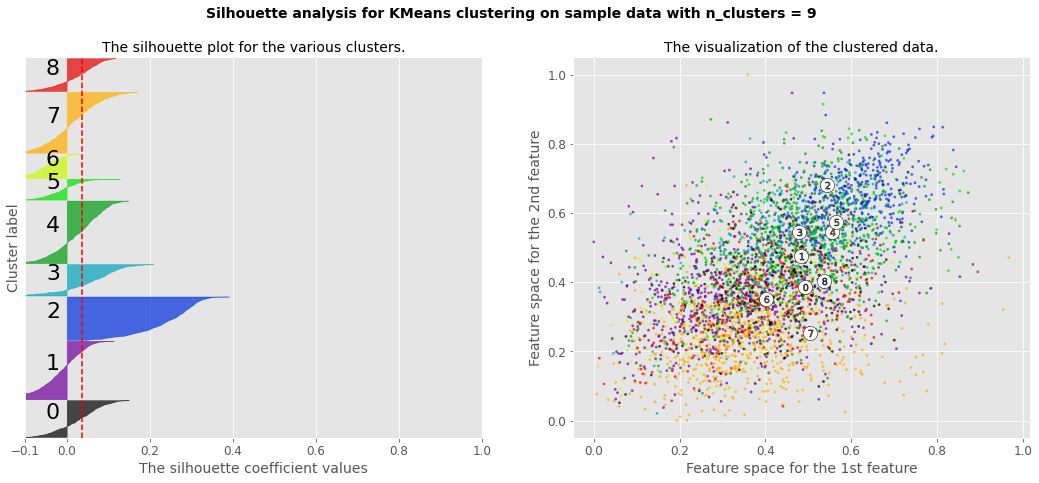

In [596]:
compara_silhouette_kmeds (np.asarray(DF2_2),[7,9])

Aplicamos el algoritmo kMeans para k=9. Generamos la matriz de confusion como método de validacion externa para ver si los agrupamientos son similares a los reales

In [597]:
kmeds2 = KMedoids(n_clusters=9, random_state=10).fit(DF2_2)  

tmp2_med = pd.DataFrame({'Labels': DF2.genre, 'Clusters': kmeds2.labels_})# Create a DataFrame with labels and varieties as columns: df
ct2_med = pd.crosstab(tmp2['Labels'], tmp2['Clusters']) # Create crosstab: ct
ct2_med

Clusters             0    1    2    3    4   5    6    7    8
Labels                                                       
ambient            100   21    5  115   75  61   35    7   23
classical          101   16    2   51   69  66    1   86    4
death-metal          2   36  440    1    2   1    3    1    0
drum-and-bass        3  184    5   14    6  12  226    1   26
jazz                14   43    0   48   23  14   32   30  217
opera               19   18    0   33   36  34    0  308   13
singer-songwriter   53   35    0   87  109  65    4    0   94
ska                  2  270   31    9    7  12   18    0  128
trance               3   98    4   10   13  15  298    2   32

### Calculamos los indices de Rand y Van Dongen 

In [598]:
from sklearn.metrics import adjusted_rand_score

# este es el mejor indice?
ari2 = adjusted_rand_score(DF2.genre, kmeds2.labels_)
ari2

0.20804876008511652

In [599]:
vanDongen(ct2_med)
# este es el mejor indice?

0.5973839298548225

### Tecnicas de reduccion de dimensionalidad


**T-distributed Stochastic Neighbor Embedding (TSNE)**

In [600]:
#Xred = pca.fit_transform(DF2_2)
#Y=pd.factorize(DF.genre)[0]

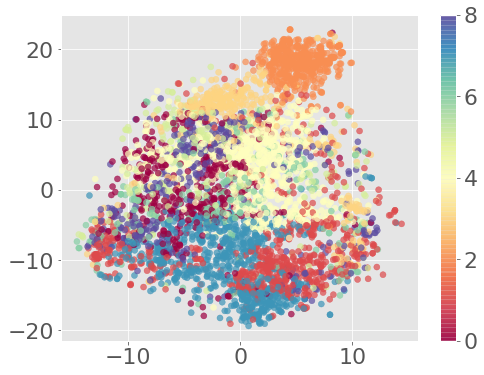

In [601]:
tsne = TSNE(n_components=2,perplexity=200)
Y=kmeds2.labels_
Xred = tsne.fit_transform(DF2_2)
plt.scatter(Xred[:,0],Xred[:,1],c=Y,cmap=plt.cm.Spectral,alpha=0.7)
plt.colorbar();

## DF3 
**Sólo con las variables de timbres**



Con los gráficos del promedio de Silhouette y SSE, tratamos de ver cuál sería la cantidad optima de clusters para este conjunto de datos

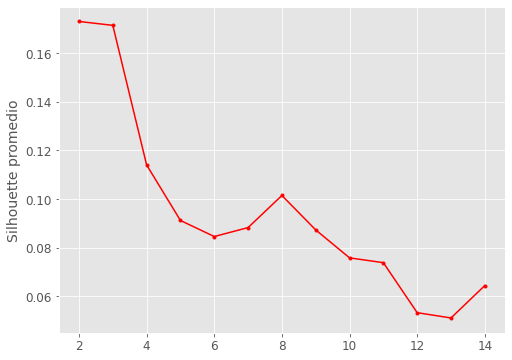

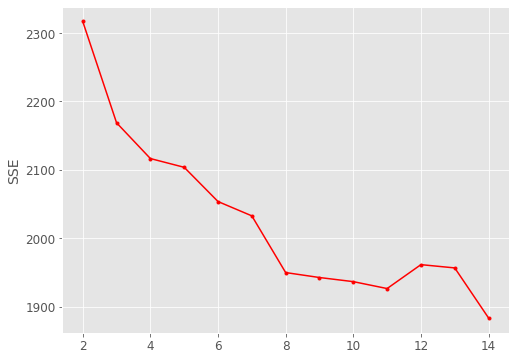

In [602]:
grafica_SIL_SSE_KMEDIODS(DF3_2)

For n_clusters = 3 The average silhouette_score is : 0.17150898399828435
For n_clusters = 9 The average silhouette_score is : 0.08731264022406508


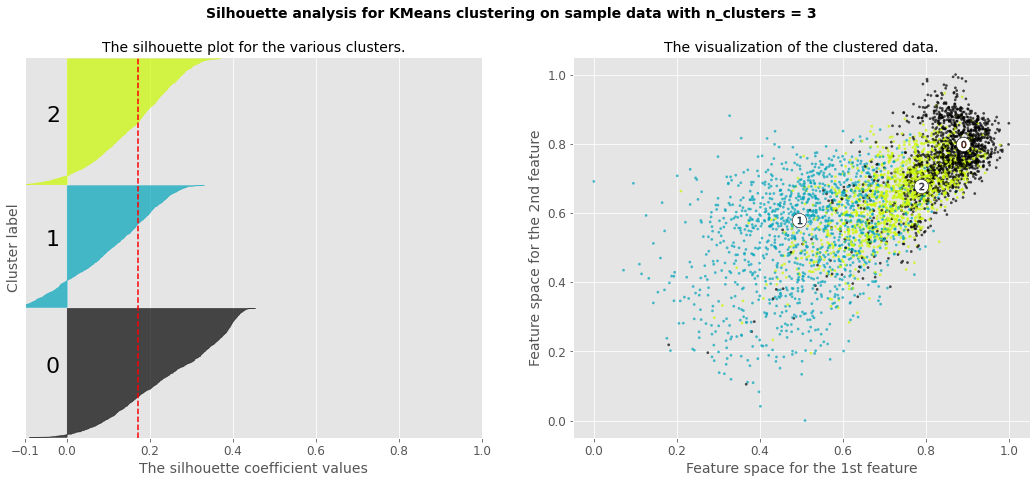

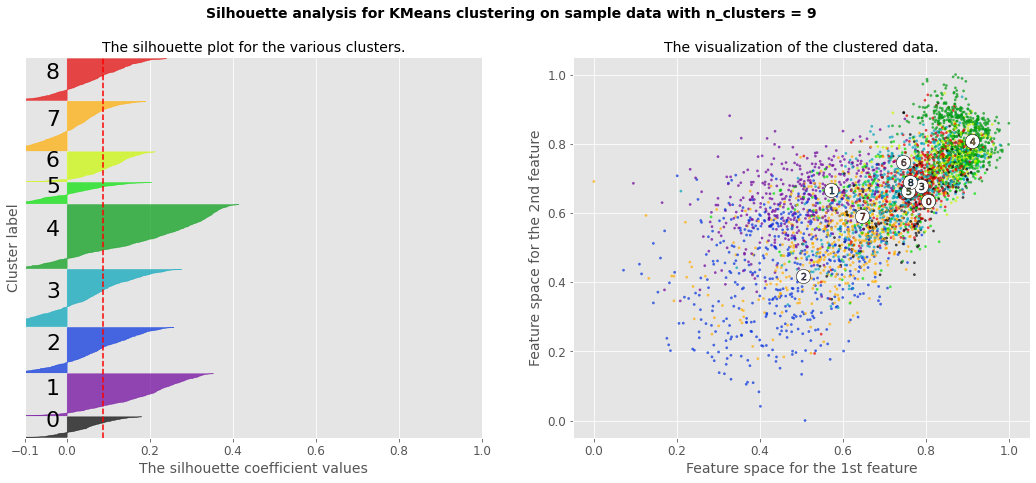

In [603]:
compara_silhouette_kmeds (np.asarray(DF3_2),[3,9])

Aplicamos el algoritmo kMeans para k=9. Generamos la matriz de confusion como método de validacion externa para ver si los agrupamientos son similares a los reales

In [604]:
kmeds3 = KMedoids(n_clusters=9, random_state=10).fit(DF3_2)  

tmp3_med = pd.DataFrame({'Labels': DF3.genre, 'Clusters': kmeds3.labels_})# Create a DataFrame with labels and varieties as columns: df
ct3_med = pd.crosstab(tmp3['Labels'], tmp3['Clusters']) # Create crosstab: ct
ct3_med

Clusters             0    1    2    3    4    5    6    7    8
Labels                                                        
ambient              1  112   16   20  134    9   16   13  121
classical            3   16   78    0   63    4    1    1  230
death-metal          2    0    0   41    1  435    0    2    5
drum-and-bass       17    5    0  267    0    6   20  161    1
jazz                74  145   23   19    7    1  126   14   12
opera               19   25  333    6    3    0    4    0   71
singer-songwriter   70  247    2   49    0    1   64    2   12
ska                265    4    0  119    0   27   58    4    0
trance               7    3    2  169    2    1   42  245    4

### Calculamos los indices de Rand y Van Dongen 

In [605]:
from sklearn.metrics import adjusted_rand_score

# este es el mejor indice?
ari3 = adjusted_rand_score(DF3.genre, kmeds3.labels_)
ari3

0.3069669646766555

In [606]:
vanDongen(ct3_med)
# este es el mejor indice?

0.5124499141385231

### Tecnicas de reduccion de dimensionalidad


**T-distributed Stochastic Neighbor Embedding (TSNE)**

In [ ]:
#Xred = pca.fit_transform(DF2_2)
#Y=pd.factorize(DF.genre)[0]

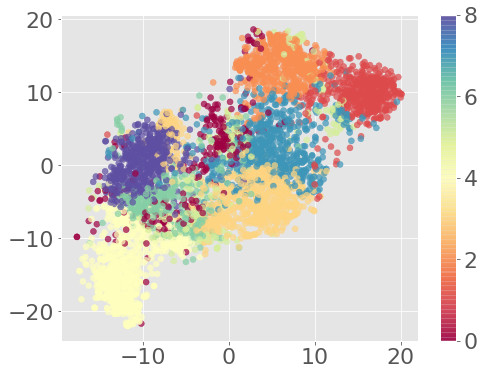

In [615]:
tsne = TSNE(n_components=2,perplexity=200)
Y=kmeds3.labels_
Xred = tsne.fit_transform(DF3_2)
plt.scatter(Xred[:,0],Xred[:,1],c=Y,cmap=plt.cm.Spectral,alpha=0.7)
plt.colorbar();

## DF4 
**Sólo con las variables de pitches**



Con los gráficos del promedio de Silhouette y SSE, tratamos de ver cuál sería la cantidad optima de clusters para este conjunto de datos

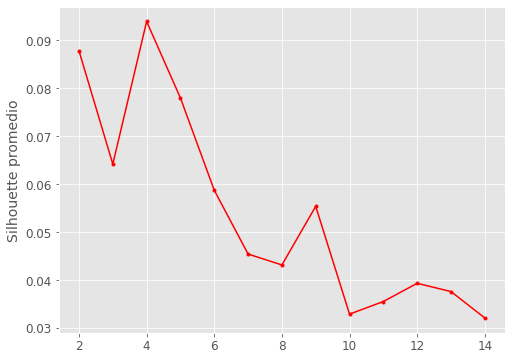

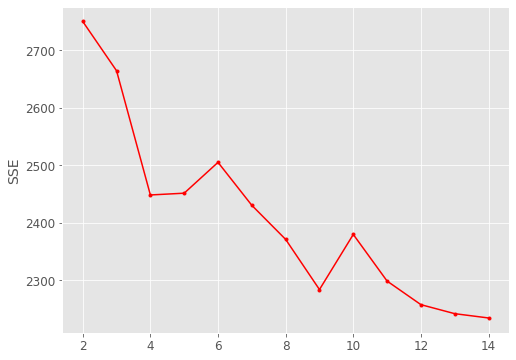

In [609]:
grafica_SIL_SSE_KMEDIODS(DF4_2)

For n_clusters = 4 The average silhouette_score is : 0.09389679873563998
For n_clusters = 9 The average silhouette_score is : 0.055346382720992446


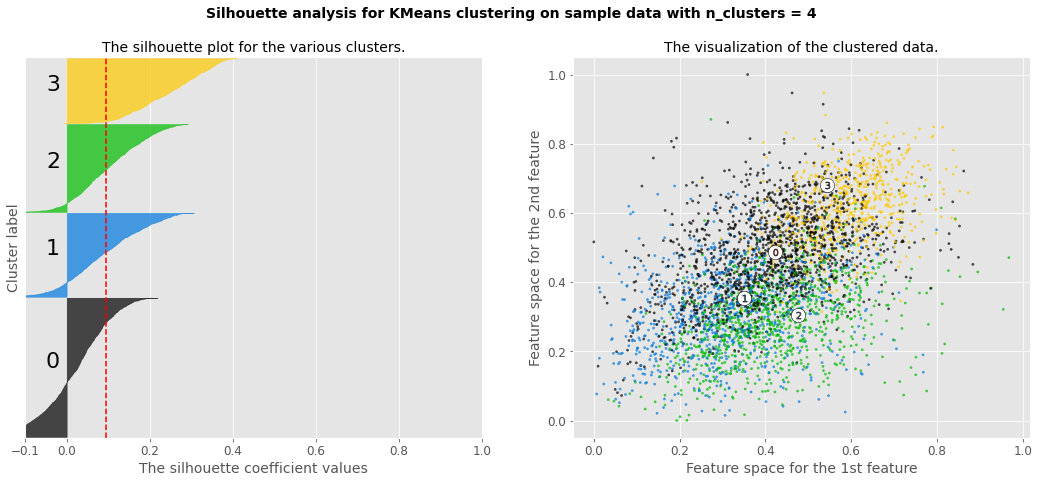

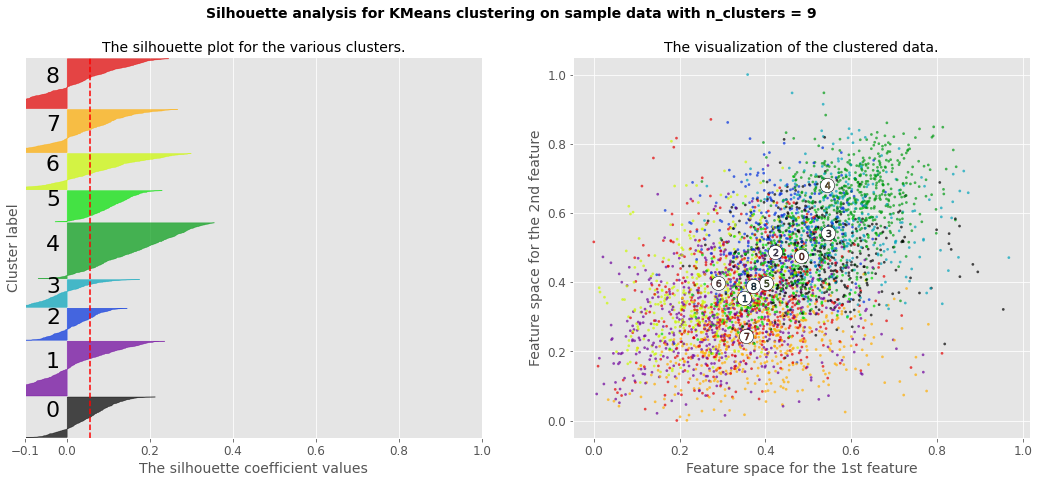

In [610]:
compara_silhouette_kmeds (np.asarray(DF4_2),[4,9])

Aplicamos el algoritmo kMeans para k=9. Generamos la matriz de confusion como método de validacion externa para ver si los agrupamientos son similares a los reales

In [611]:
kmeds4 = KMedoids(n_clusters=9, random_state=10).fit(DF4_2)  

tmp4_med = pd.DataFrame({'Labels': DF4.genre, 'Clusters': kmeds4.labels_})# Create a DataFrame with labels and varieties as columns: df
ct4_med = pd.crosstab(tmp4['Labels'], tmp4['Clusters']) # Create crosstab: ct
ct4_med

Clusters             0   1    2    3   4   5   6    7    8
Labels                                                    
ambient              6  57   41   39  79  84  56   33   47
classical            2  51   81    6  79  30  62   18   67
death-metal        395   2    3   21   1   1   1   50   12
drum-and-bass       11   0   22  131   0   9  21  215   68
jazz                11   5  165   33  19  35  20   47   86
opera                2  21  131    6  27  48  69   42  115
singer-songwriter    2  67   70   15  60  60  71   14   88
ska                 70   3   40   53   7  19  37   88  160
trance              38   0   16  202   0   6  18  123   72

### Calculamos los indices de Rand y Van Dongen 

In [612]:
from sklearn.metrics import adjusted_rand_score

# este es el mejor indice?
ari4 = adjusted_rand_score(DF4.genre, kmeds4.labels_)
ari4

0.12921394930621816

In [613]:
vanDongen(ct4_med)
# este es el mejor indice?

0.7475226195605342

### Tecnicas de reduccion de dimensionalidad


**T-distributed Stochastic Neighbor Embedding (TSNE)**

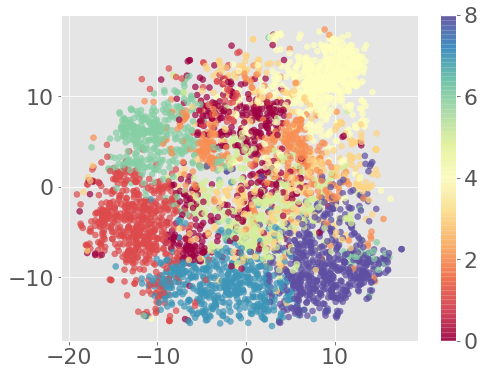

In [616]:
tsne = TSNE(n_components=2,perplexity=200)
Y=kmeds4.labels_
Xred = tsne.fit_transform(DF4_2)
plt.scatter(Xred[:,0],Xred[:,1],c=Y,cmap=plt.cm.Spectral,alpha=0.7)
plt.colorbar();

## DF5 
**Sólo con Audio Features (Alto Nivel)**

Con los gráficos del promedio de Silhouette y SSE, tratamos de ver cuál sería la cantidad optima de clusters para este conjunto de datos

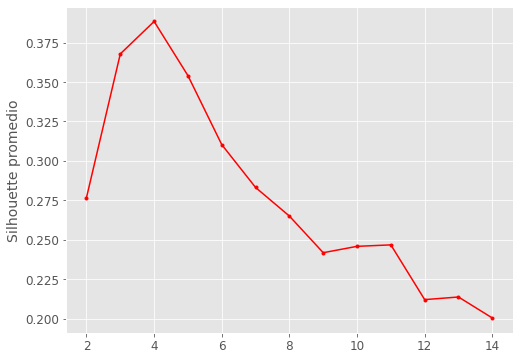

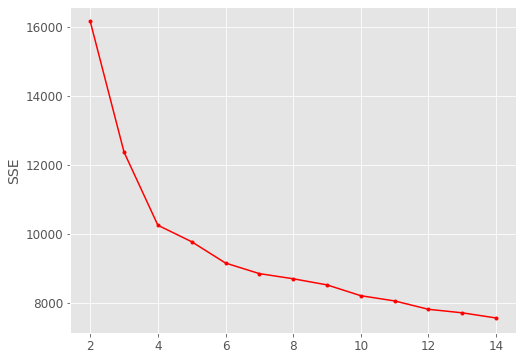

In [617]:
grafica_SIL_SSE_KMEDIODS(DF5_2)

For n_clusters = 4 The average silhouette_score is : 0.3883693766193319
For n_clusters = 9 The average silhouette_score is : 0.24176920659815695


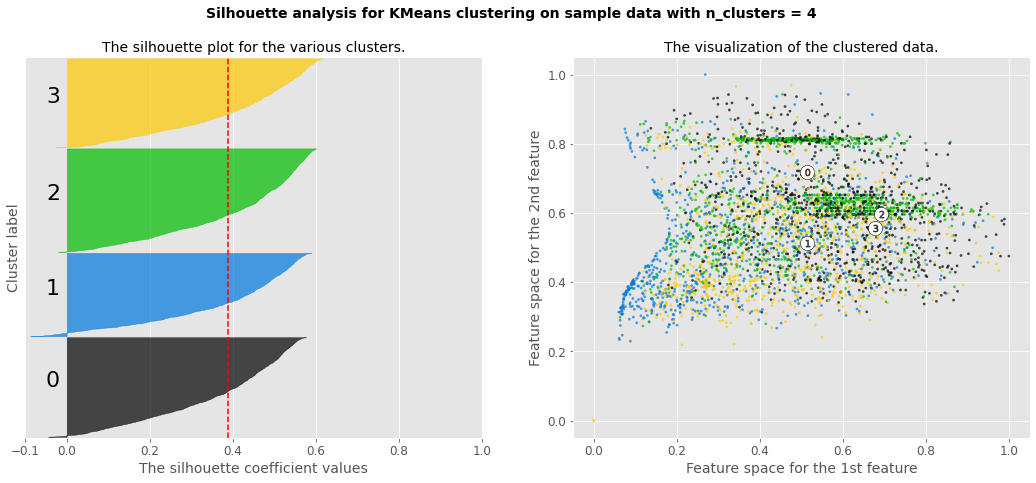

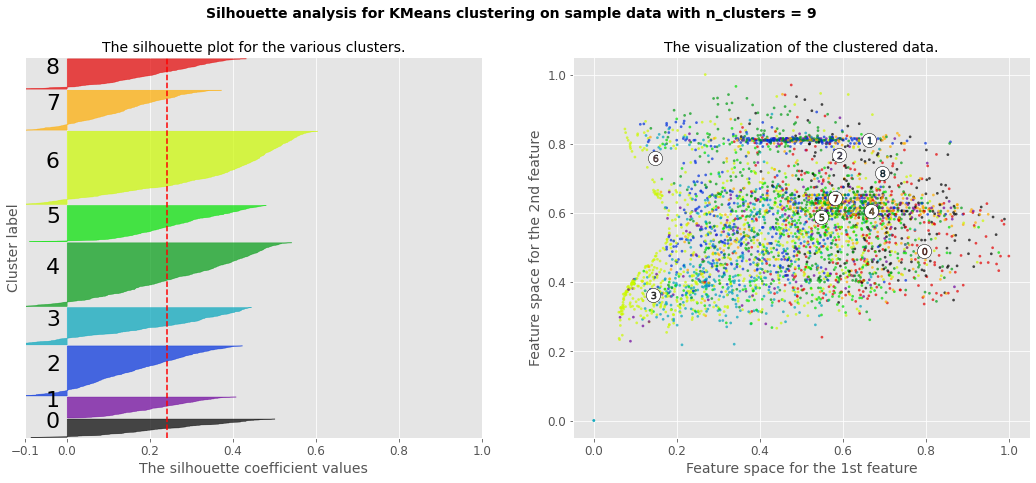

In [618]:
compara_silhouette_kmeds (np.asarray(DF5_2),[4,9])

Aplicamos el algoritmo kMeans para k=9. Generamos la matriz de confusion como método de validacion externa para ver si los agrupamientos son similares a los reales

In [619]:
kmeds5 = KMedoids(n_clusters=9, random_state=10).fit(DF5_2)  

tmp5_med = pd.DataFrame({'Labels': DF5.genre, 'Clusters': kmeds5.labels_})# Create a DataFrame with labels and varieties as columns: df
ct5_med = pd.crosstab(tmp5['Labels'], tmp5['Clusters']) # Create crosstab: ct
ct5_med

Clusters             0    1    2    3    4    5    6    7    8
Labels                                                        
ambient              1    1   65  153    4  176    0    2   16
classical            1    0    0   39   19  223    0    0   29
death-metal          0  156   59    6    0    1    0  202    1
drum-and-bass        6  165  133    1    0    0   12  141    0
jazz                98    1   23  104   13   61    5    0   91
opera               11    0    0   10  181   29    0    0  163
singer-songwriter  199   17    4   18   10    8   34    0  155
ska                 60   82   13   23    0    1  280    1    1
trance              13  128  238    6    0    4   21   54    0

### Calculamos los indices de Rand y Van Dongen 

In [620]:
from sklearn.metrics import adjusted_rand_score

# este es el mejor indice?
ari5 = adjusted_rand_score(DF5.genre, kmeds5.labels_)
ari5

0.2553034698341249

In [621]:
vanDongen(ct5_med)
# este es el mejor indice?

0.6082695252679938

### Tecnicas de reduccion de dimensionalidad


**T-distributed Stochastic Neighbor Embedding (TSNE)**

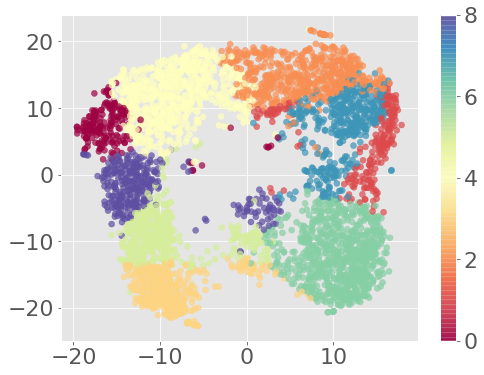

In [622]:
tsne = TSNE(n_components=2,perplexity=200)
Y=kmeds5.labels_
Xred = tsne.fit_transform(DF5_2)
plt.scatter(Xred[:,0],Xred[:,1],c=Y,cmap=plt.cm.Spectral,alpha=0.7)
plt.colorbar();

# Algoritmo Jerárquico

##DF1 
**Todas las variables numéricas, sin los NA**

Primero evaluacion el indice/distancia cofenetico para ver cual metodo nos conviene usar.

LINKAGE=Perform hierarchical/agglomerative clustering.

In [623]:
indices_cofeneticos_varios(DF1)

Indice cofenetico para metodo centroide y metrica euclidean 0.5918390563440779
Indice cofenetico para metodo average y metrica euclidean 0.6256679035860008
Indice cofenetico para metodo complete y metrica euclidean 0.40883410901631434
Indice cofenetico para metodo single y metrica euclidean 0.5386523302634119
Indice cofenetico para metodo ward y metrica euclidean 0.4410430358111406
Indice cofenetico para metodo median y metrica euclidean 0.48832414249386064
Indice cofenetico para metodo average y metrica chebyshev 0.528123118173686
Indice cofenetico para metodo complete y metrica chebyshev 0.3205922314777692
Indice cofenetico para metodo single y metrica chebyshev 0.5755788756604815
Indice cofenetico para metodo average y metrica mahalanobis 0.49412990812239077
Indice cofenetico para metodo complete y metrica mahalanobis 0.399137075870766
Indice cofenetico para metodo single y metrica mahalanobis 0.4741052080202942


Aplicamos algoritmo jerarquico Aglomerativo con el mejor indice cofenetico

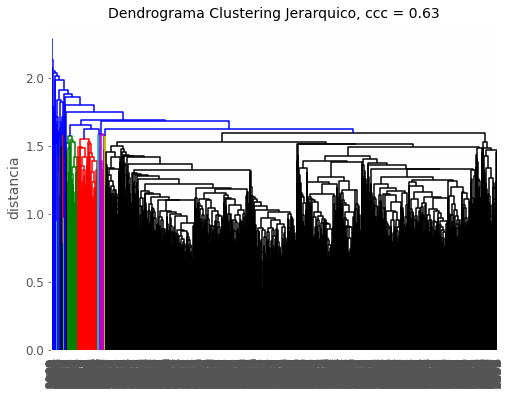

In [680]:
DF1_3=scaler.fit_transform(DF1)
z1 = linkage(DF1_3, method='average', metric='euclidean')
c,_=cophenet(z1,pdist(DF1_3))

plt.figure()
DN1 = dendrogram(z1)
plt.title('Dendrograma Clustering Jerarquico, ccc = %0.2f'%c, fontsize=14)
plt.ylabel('distancia', fontsize=14)
plt.tick_params(axis='both',labelsize=12)
plt.show()


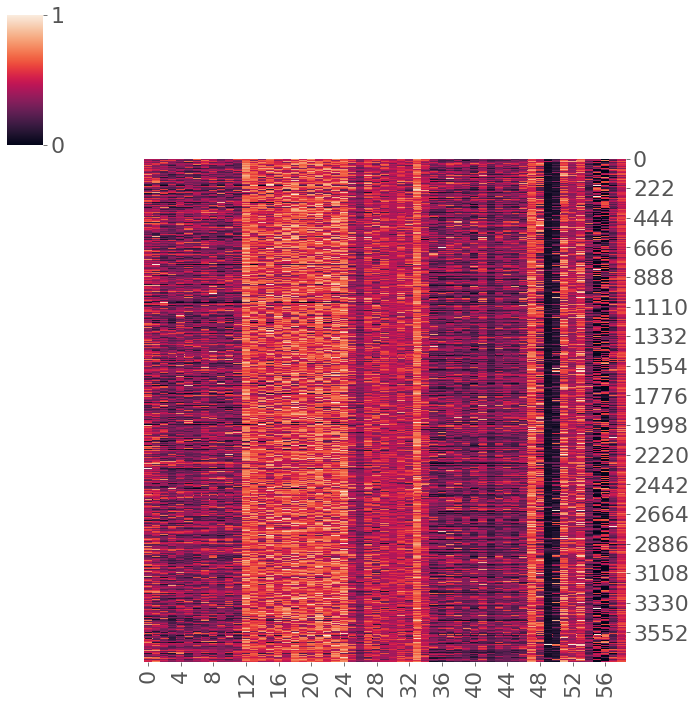

In [625]:
sns.clustermap(DF1_3, method='average', metric='euclidean',row_cluster=False,col_cluster=False)

Otra forma de ver el mismo dendograma anterior

/usr/local/lib/python3.6/dist-packages/seaborn/matrix.py:659: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


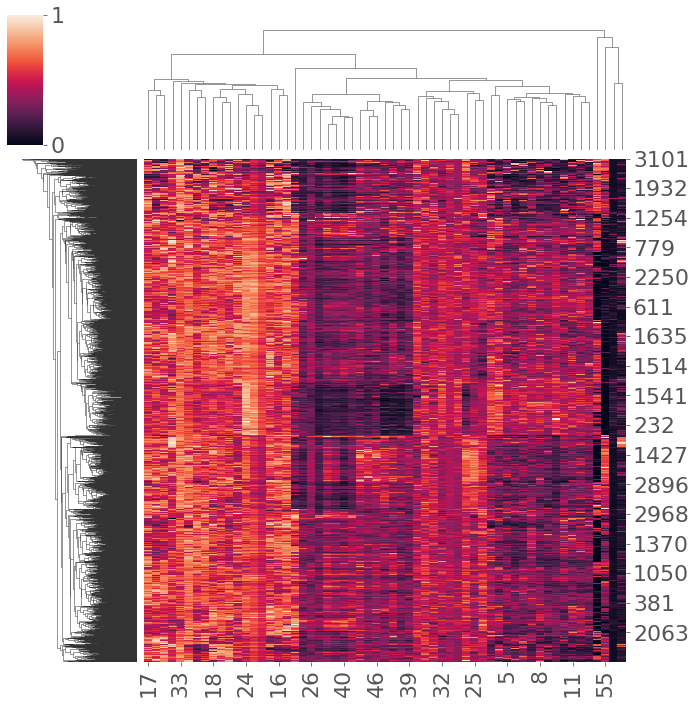

In [626]:
sns.clustermap(DF1_3, method='average', metric='euclidean')

### Indice Rand
Evaluamos el indice Rand en el jerarquico generado, segun distintos criterios

In [684]:
#fcluster
#Form flat clusters from the hierarchical clustering defined by the given linkage matrix.
cluster_labels = fcluster(z1,2, criterion='distance')
print(np.unique(cluster_labels))
print(adjusted_rand_score(DF.genre, cluster_labels))

[1 2 3 4 5 6 7 8]
0.0005033936965290907


In [694]:
cluster_labels = fcluster(z1,9, criterion='maxclust')
print(np.unique(cluster_labels))
print(adjusted_rand_score(DF.genre, cluster_labels))

[1 2 3 4 5 6 7 8 9]
0.0005892334652663513


##DF2 
**Sólo con las variables de timbres y pitches**

Primero evaluacion el indice/distancia cofenetico para ver cual metodo nos conviene usar.

LINKAGE=Perform hierarchical/agglomerative clustering.

In [634]:
indices_cofeneticos_varios(DF2_2)

Indice cofenetico para metodo centroide y metrica euclidean 0.6423204859435492
Indice cofenetico para metodo average y metrica euclidean 0.6791483290069812
Indice cofenetico para metodo complete y metrica euclidean 0.3330323736280513
Indice cofenetico para metodo single y metrica euclidean 0.6118232144949796
Indice cofenetico para metodo ward y metrica euclidean 0.3535328945503854
Indice cofenetico para metodo median y metrica euclidean 0.5189700793839069
Indice cofenetico para metodo average y metrica chebyshev 0.647137475140395
Indice cofenetico para metodo complete y metrica chebyshev 0.3036663804558109
Indice cofenetico para metodo single y metrica chebyshev 0.6319207279802193
Indice cofenetico para metodo average y metrica mahalanobis 0.5565623645659676
Indice cofenetico para metodo complete y metrica mahalanobis 0.40035416926986106
Indice cofenetico para metodo single y metrica mahalanobis 0.5452943534578544


Aplicamos algoritmo jerarquico Aglomerativo con el mejor indice cofenetico

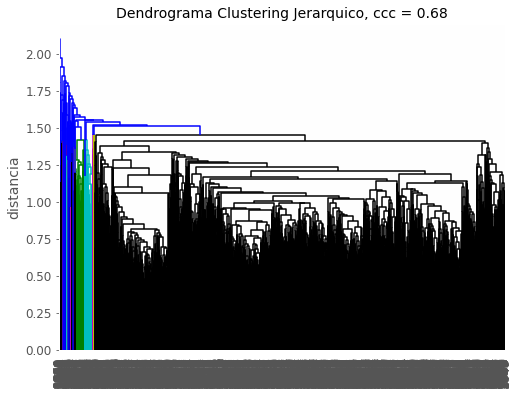

In [635]:
DF2_3=scaler.fit_transform(DF2_2)
z1 = linkage(DF2_3, method='average', metric='euclidean')
c,_=cophenet(z1,pdist(DF2_3))

plt.figure()
DN1 = dendrogram(z1)
plt.title('Dendrograma Clustering Jerarquico, ccc = %0.2f'%c, fontsize=14)
plt.ylabel('distancia', fontsize=14)
plt.tick_params(axis='both',labelsize=12)
plt.show()


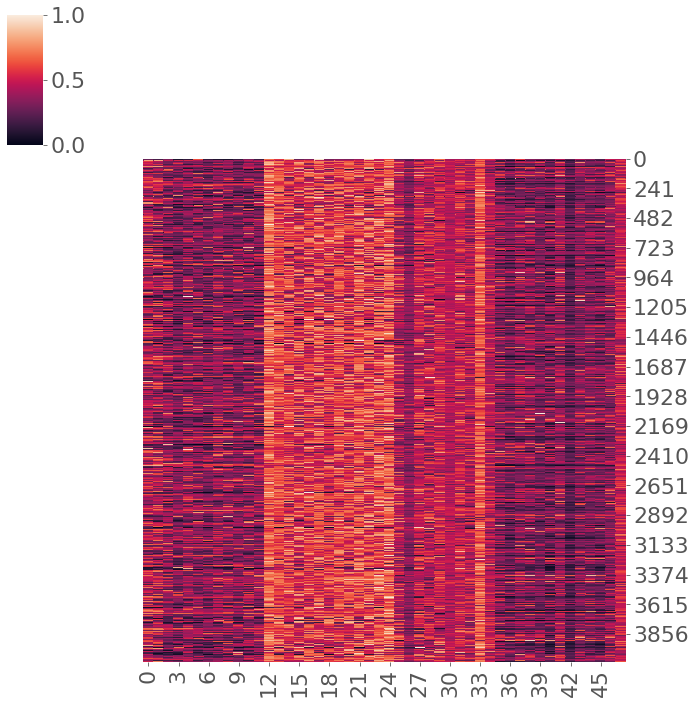

In [636]:
sns.clustermap(DF2_3, method='average', metric='euclidean',row_cluster=False,col_cluster=False)

Otra forma de ver el mismo dendograma anterior

/usr/local/lib/python3.6/dist-packages/seaborn/matrix.py:659: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


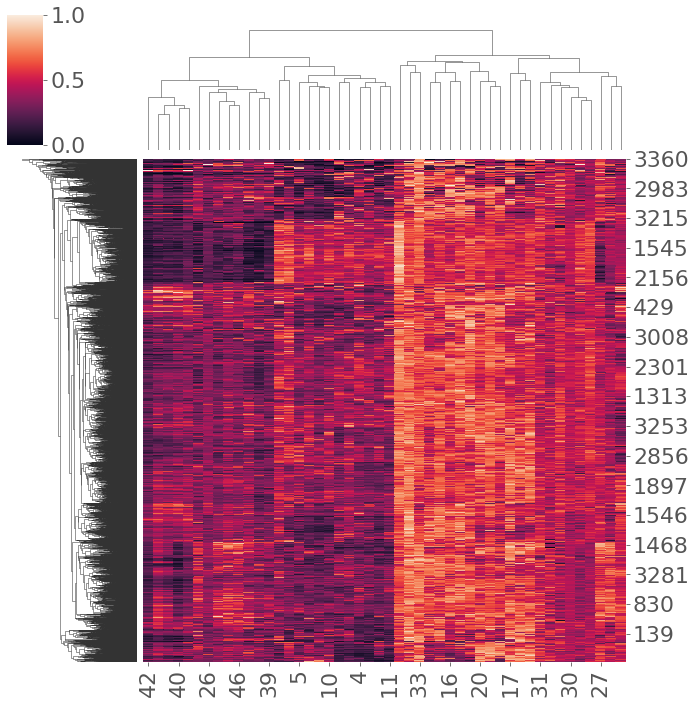

In [637]:
sns.clustermap(DF2_3, method='average', metric='euclidean')

### Indice Rand
Evaluamos el indice Rand en el jerarquico generado, segun distintos criterios

In [638]:
#fcluster
#Form flat clusters from the hierarchical clustering defined by the given linkage matrix.
cluster_labels = fcluster(z1,1.8, criterion='distance')
print(np.unique(cluster_labels))
print(adjusted_rand_score(DF2.genre, cluster_labels))

[1 2 3 4 5 6 7]
0.000584965938471288


In [639]:
cluster_labels = fcluster(z1, 9, criterion='maxclust')
print(np.unique(cluster_labels))
print(adjusted_rand_score(DF2.genre, cluster_labels))

[1 2 3 4 5 6 7 8 9]
0.0011678666992467244


## DF3 
**Sólo con las variables de timbres**

Primero evaluacion el indice/distancia cofenetico para ver cual metodo nos conviene usar.

LINKAGE=Perform hierarchical/agglomerative clustering.

In [640]:
indices_cofeneticos_varios(DF3_2)

Indice cofenetico para metodo centroide y metrica euclidean 0.6169091021844606
Indice cofenetico para metodo average y metrica euclidean 0.6269686707753904
Indice cofenetico para metodo complete y metrica euclidean 0.3893336601532989
Indice cofenetico para metodo single y metrica euclidean 0.4637221290498104
Indice cofenetico para metodo ward y metrica euclidean 0.4295619713379506
Indice cofenetico para metodo median y metrica euclidean 0.4688496432899131
Indice cofenetico para metodo average y metrica chebyshev 0.6222517688356394
Indice cofenetico para metodo complete y metrica chebyshev 0.4002444688406753
Indice cofenetico para metodo single y metrica chebyshev 0.481521737602178
Indice cofenetico para metodo average y metrica mahalanobis 0.434096687250896
Indice cofenetico para metodo complete y metrica mahalanobis 0.2665711614042721
Indice cofenetico para metodo single y metrica mahalanobis 0.3763271704442318


Aplicamos algoritmo jerarquico Aglomerativo con el mejor indice cofenetico

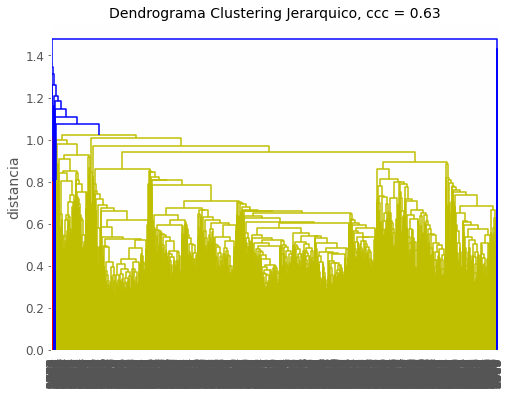

In [641]:
DF3_3=scaler.fit_transform(DF3_2)
z1 = linkage(DF3_3, method='average', metric='euclidean')
c,_=cophenet(z1,pdist(DF3_3))

plt.figure()
DN1 = dendrogram(z1)
plt.title('Dendrograma Clustering Jerarquico, ccc = %0.2f'%c, fontsize=14)
plt.ylabel('distancia', fontsize=14)
plt.tick_params(axis='both',labelsize=12)
plt.show()


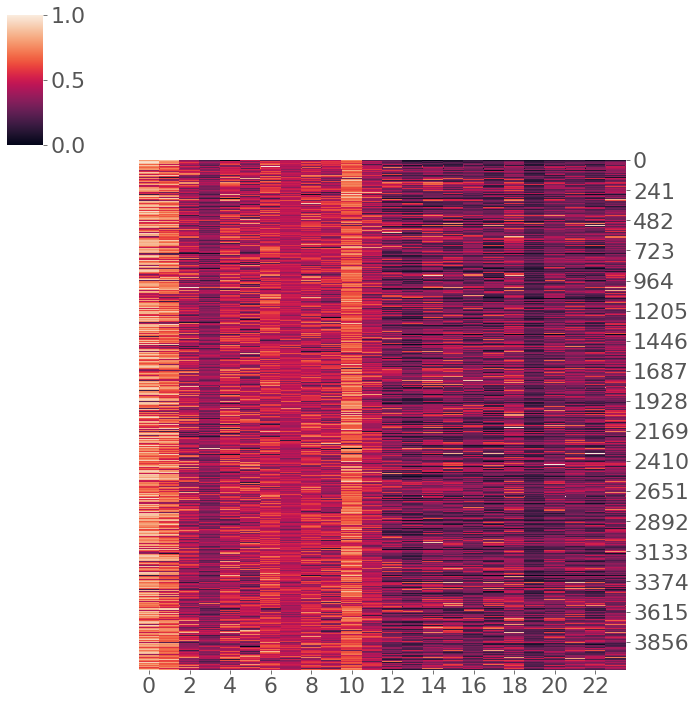

In [642]:
sns.clustermap(DF3_3, method='average', metric='euclidean',row_cluster=False,col_cluster=False)

Otra forma de ver el mismo dendograma anterior

/usr/local/lib/python3.6/dist-packages/seaborn/matrix.py:659: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


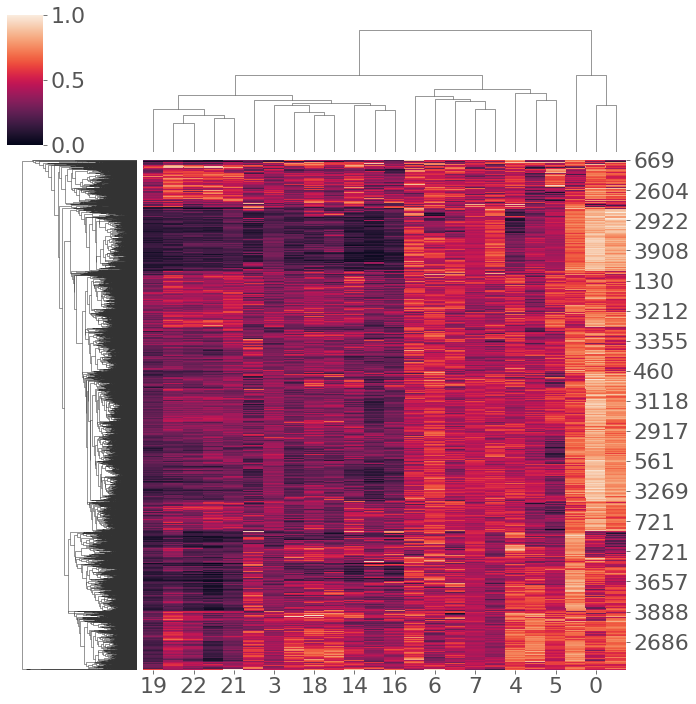

In [643]:
sns.clustermap(DF3_3, method='average', metric='euclidean')

### Indice Rand
Evaluamos el indice Rand en el jerarquico generado, segun distintos criterios

In [657]:
#fcluster
#Form flat clusters from the hierarchical clustering defined by the given linkage matrix.
cluster_labels = fcluster(z1,1.3, criterion='distance')
print(np.unique(cluster_labels))
print(adjusted_rand_score(DF3.genre, cluster_labels))

[1 2 3 4 5 6 7]
4.542121585803003e-05


In [658]:
cluster_labels = fcluster(z1, 9, criterion='maxclust')
print(np.unique(cluster_labels))
print(adjusted_rand_score(DF3.genre, cluster_labels))

[1 2 3 4 5 6 7 8 9]
0.00019363686109281813


## DF4 
**Sólo con las variables de pitches**

Primero evaluacion el indice/distancia cofenetico para ver cual metodo nos conviene usar.

LINKAGE=Perform hierarchical/agglomerative clustering.

In [659]:
indices_cofeneticos_varios(DF4_2)

Indice cofenetico para metodo centroide y metrica euclidean 0.698695150290856
Indice cofenetico para metodo average y metrica euclidean 0.699667141080475
Indice cofenetico para metodo complete y metrica euclidean 0.5203466194905766
Indice cofenetico para metodo single y metrica euclidean 0.6599046638092292
Indice cofenetico para metodo ward y metrica euclidean 0.33009626525778335
Indice cofenetico para metodo median y metrica euclidean 0.5340219270544478
Indice cofenetico para metodo average y metrica chebyshev 0.6804630016292588
Indice cofenetico para metodo complete y metrica chebyshev 0.36474813720384147
Indice cofenetico para metodo single y metrica chebyshev 0.681774324008902
Indice cofenetico para metodo average y metrica mahalanobis 0.6312195331319028
Indice cofenetico para metodo complete y metrica mahalanobis 0.41127818423537105
Indice cofenetico para metodo single y metrica mahalanobis 0.6273055851290128


Aplicamos algoritmo jerarquico Aglomerativo con el mejor indice cofenetico

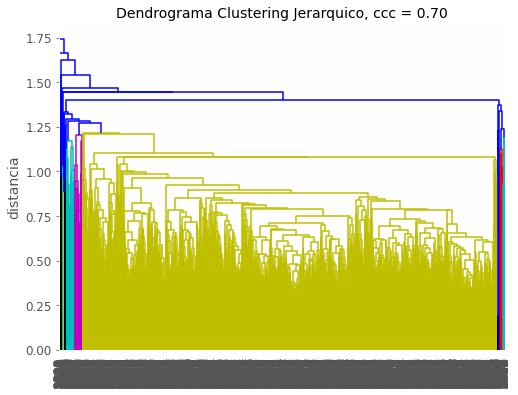

In [660]:
DF4_3=scaler.fit_transform(DF4_2)
z1 = linkage(DF4_3, method='average', metric='euclidean')
c,_=cophenet(z1,pdist(DF4_3))

plt.figure()
DN1 = dendrogram(z1)
plt.title('Dendrograma Clustering Jerarquico, ccc = %0.2f'%c, fontsize=14)
plt.ylabel('distancia', fontsize=14)
plt.tick_params(axis='both',labelsize=12)
plt.show()


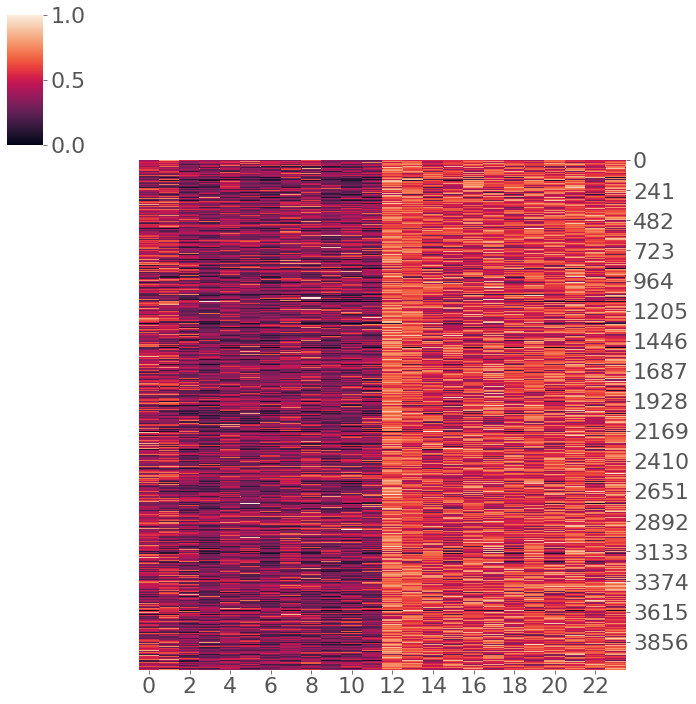

In [661]:
sns.clustermap(DF4_3, method='average', metric='euclidean',row_cluster=False,col_cluster=False)

Otra forma de ver el mismo dendograma anterior

/usr/local/lib/python3.6/dist-packages/seaborn/matrix.py:659: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


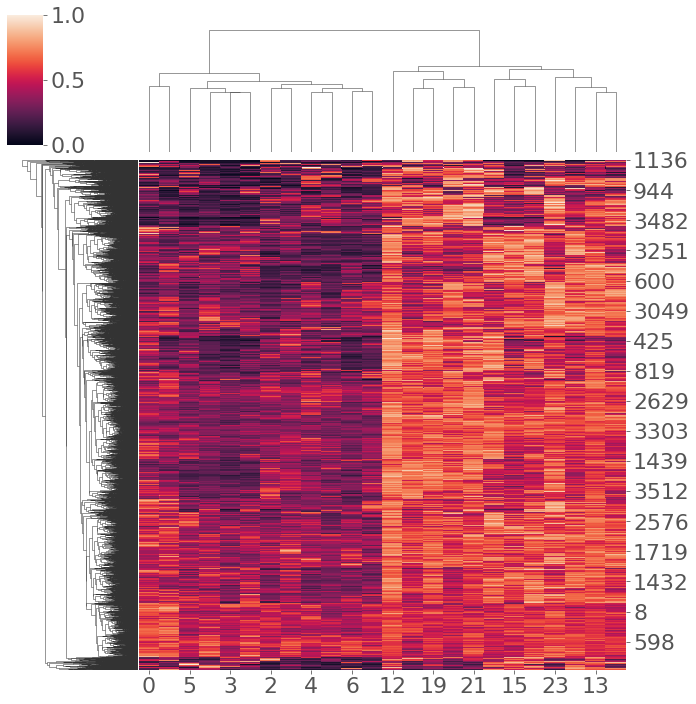

In [662]:
sns.clustermap(DF4_3, method='average', metric='euclidean')

### Indice Rand
Evaluamos el indice Rand en el jerarquico generado, segun distintos criterios

In [668]:
#fcluster
#Form flat clusters from the hierarchical clustering defined by the given linkage matrix.
cluster_labels = fcluster(z1,1.45, criterion='distance')
print(np.unique(cluster_labels))
print(adjusted_rand_score(DF4.genre, cluster_labels))

[1 2 3 4 5 6]
0.00032227911394588


In [664]:
cluster_labels = fcluster(z1, 9, criterion='maxclust')
print(np.unique(cluster_labels))
print(adjusted_rand_score(DF4.genre, cluster_labels))

[1 2 3 4 5 6 7 8 9]
0.00046595291814487415


## DF5 
**Sólo con Audio Features (Alto Nivel)**

Primero evaluacion el indice/distancia cofenetico para ver cual metodo nos conviene usar.

LINKAGE=Perform hierarchical/agglomerative clustering.

In [669]:
indices_cofeneticos_varios(DF5_2)

Indice cofenetico para metodo centroide y metrica euclidean 0.6222262381671045
Indice cofenetico para metodo average y metrica euclidean 0.6266715668544767
Indice cofenetico para metodo complete y metrica euclidean 0.5372152432495945
Indice cofenetico para metodo single y metrica euclidean 0.27663672039033615
Indice cofenetico para metodo ward y metrica euclidean 0.5782743469884986
Indice cofenetico para metodo median y metrica euclidean 0.4085361180461488
Indice cofenetico para metodo average y metrica chebyshev 0.6021872130881908
Indice cofenetico para metodo complete y metrica chebyshev 0.414944803901543
Indice cofenetico para metodo single y metrica chebyshev 0.3020741920376776
Indice cofenetico para metodo average y metrica mahalanobis 0.3878876849176981
Indice cofenetico para metodo complete y metrica mahalanobis 0.22328282175259237
Indice cofenetico para metodo single y metrica mahalanobis 0.26781168019991847


Aplicamos algoritmo jerarquico Aglomerativo con el mejor indice cofenetico

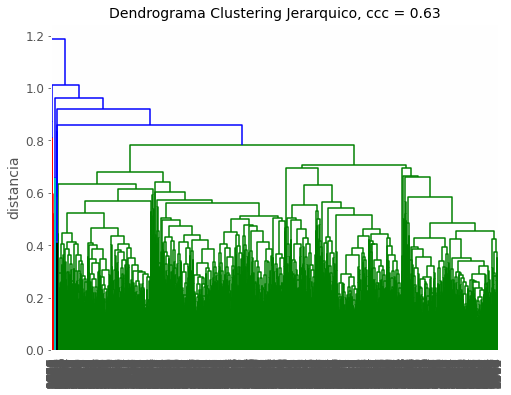

In [670]:
DF5_3=scaler.fit_transform(DF5_2)
z1 = linkage(DF5_3, method='average', metric='euclidean')
c,_=cophenet(z1,pdist(DF5_3))

plt.figure()
DN1 = dendrogram(z1)
plt.title('Dendrograma Clustering Jerarquico, ccc = %0.2f'%c, fontsize=14)
plt.ylabel('distancia', fontsize=14)
plt.tick_params(axis='both',labelsize=12)
plt.show()


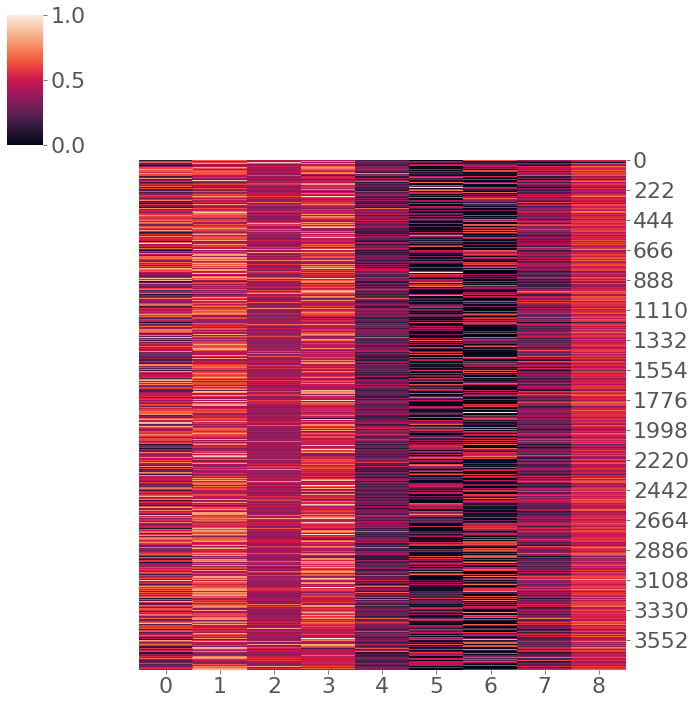

In [671]:
sns.clustermap(DF5_3, method='average', metric='euclidean',row_cluster=False,col_cluster=False)

Otra forma de ver el mismo dendograma anterior

/usr/local/lib/python3.6/dist-packages/seaborn/matrix.py:659: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


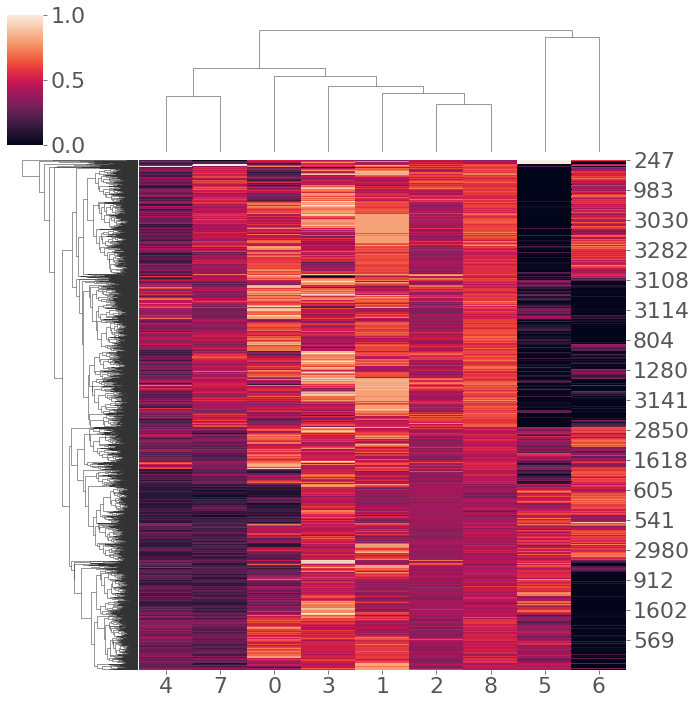

In [672]:
sns.clustermap(DF5_3, method='average', metric='euclidean')

### Indice Rand
Evaluamos el indice Rand en el jerarquico generado, segun distintos criterios

In [678]:
#fcluster
#Form flat clusters from the hierarchical clustering defined by the given linkage matrix.
cluster_labels = fcluster(z1,0.9, criterion='distance')
print(np.unique(cluster_labels))
print(adjusted_rand_score(DF5.genre, cluster_labels))

[1 2 3 4 5]
0.0004603956269070015


In [674]:
cluster_labels = fcluster(z1, 9, criterion='maxclust')
print(np.unique(cluster_labels))
print(adjusted_rand_score(DF5.genre, cluster_labels))

[1 2 3 4 5 6 7 8 9]
0.0004356773941128205
